# Autoencoder Self Study

In [16]:
# -*- coding: utf-8 -*-
# The below is for auto-reloading external modules after they are changed, such as those in ./utils.
# Issue: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy as np
from utils.data_utils import get_mnist # Helper function. Use it out of the box. YW: needed to load the MNIST dataset.

# Constants
DATA_DIR = './data/mnist' # Location we will keep the data.
SEED = 111111

# If datasets are not at specified location, they will be downloaded.
train_imgs, train_lbls = get_mnist(data_dir=DATA_DIR, train=True, download=True)
test_imgs, test_lbls = get_mnist(data_dir=DATA_DIR, train=False, download=True)
#YW: store the training/testing images and labels.


print("[train_imgs] Type: ", type(train_imgs), "|| Shape:", train_imgs.shape, "|| Data type: ", train_imgs.dtype )
print("[train_lbls] Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, "|| Data type: ", train_lbls.dtype )
print('Class labels in train = ', np.unique(train_lbls))

print("[test_imgs] Type: ", type(test_imgs), "|| Shape:", test_imgs.shape, " || Data type: ", test_imgs.dtype )
print("[test_lbls] Type: ", type(test_lbls), "|| Shape:", test_lbls.shape, " || Data type: ", test_lbls.dtype )
print('Class labels in test = ', np.unique(test_lbls))

N_tr_imgs = train_imgs.shape[0] # N hereafter. Number of training images in database.
H_height = train_imgs.shape[1] # H hereafter
W_width = train_imgs.shape[2] # W hereafter
C_classes = len(np.unique(train_lbls)) # C hereafter, YW: Unique lable of training dataset, 0 - 9: 10 unique labels

[train_imgs] Type:  <class 'numpy.ndarray'> || Shape: (60000, 28, 28) || Data type:  uint8
[train_lbls] Type:  <class 'numpy.ndarray'> || Shape: (60000,) || Data type:  int16
Class labels in train =  [0 1 2 3 4 5 6 7 8 9]
[test_imgs] Type:  <class 'numpy.ndarray'> || Shape: (10000, 28, 28)  || Data type:  uint8
[test_lbls] Type:  <class 'numpy.ndarray'> || Shape: (10000,)  || Data type:  int16
Class labels in test =  [0 1 2 3 4 5 6 7 8 9]


In [17]:
%matplotlib inline
from utils.plotting import plot_grid_of_images # Helper functions, use out of the box.
plot_grid_of_images(train_imgs[0:100], n_imgs_per_row=10)
#YW: Selects the first 100 training images, Specifies 10 images to display per row in the grid. 10x10 grid, each 1x1 represent an image


n_rows= 10


## Data pre-processing

**Example for one hot encodding:** \
 [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # One-hot for label 0\
 [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # One-hot for label 2\
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # One-hot for label 1\
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]   # One-hot for label 9


**Rescaling is Needed** \
The original image pixel values are integers in the range [0, 255] (as is standard for grayscale images). To facilitate learning in neural networks:\

It’s common to normalize the data to a smaller range, e.g., [-1, 1].\
A zero-centered signal (mean around 0) with smaller magnitude can help avoid:\
Exploding gradients: When values are too large, causing unstable learning.\
Vanishing gradients: When values are too small, causing the model to stop learning.

**Vectorise the 2D images into 1D vectors** \
For MLP to take input

In [19]:
# a) Change representation of labels to one-hot vectors of length C=10.
train_lbls_onehot = np.zeros(shape=(train_lbls.shape[0], C_classes ) )
#YW: a numpy array of zeros, like the above one hot encoddinge example but all 0, rows = number of observations in train_lbls

train_lbls_onehot[ np.arange(train_lbls_onehot.shape[0]), train_lbls ] = 1
#YW: np.arange(train_lbls_onehot.shape[0]): telling that we will modify all the rows, shape[0] = number of rows
#YW: train_lbls has a value of 0 -9, which means if the first input has a lable = 3, then it will be train_lbls_onehot[0,3] = 1. the process repeat until the end of dataset ?

test_lbls_onehot = np.zeros(shape=(test_lbls.shape[0], C_classes ) )
test_lbls_onehot[ np.arange(test_lbls_onehot.shape[0]), test_lbls ] = 1
#YW: Repeat for test

print("BEFORE: [train_lbls]        Type: ", type(train_lbls), "|| Shape:", train_lbls.shape, " || Data type: ", train_lbls.dtype )
print("AFTER : [train_lbls_onehot] Type: ", type(train_lbls_onehot), "|| Shape:", train_lbls_onehot.shape, " || Data type: ", train_lbls_onehot.dtype )

BEFORE: [train_lbls]        Type:  <class 'numpy.ndarray'> || Shape: (60000,)  || Data type:  int16
AFTER : [train_lbls_onehot] Type:  <class 'numpy.ndarray'> || Shape: (60000, 10)  || Data type:  float64


In [20]:
# b) Re-scale image intensities, from [0,255] to [-1, +1].
# This commonly facilitates learning:
# A zero-centered signal with small magnitude allows avoiding exploding/vanishing problems easier.
from utils.data_utils import normalize_int_whole_database # Helper function. Use out of the box.
train_imgs = normalize_int_whole_database(train_imgs, norm_type="minus_1_to_1")
test_imgs = normalize_int_whole_database(test_imgs, norm_type="minus_1_to_1")

# Lets plot one image.
from utils.plotting import plot_image # Helper function, use out of the box.
index = 0  # Try any, up to 60000
print("Plotting image of index: [", index, "]")
print("Class label for this image is: ", train_lbls[index])
print("One-hot label representation: [", train_lbls_onehot[index], "]")
plot_image(train_imgs[index])
# Notice the magnitude of intensities. Black is now negative and white is positive float.
# Compare with intensities of figure further above.

Plotting image of index: [ 0 ]
Class label for this image is:  5
One-hot label representation: [ [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] ]


In [21]:
# c) Flatten the images, from 2D matrices to 1D vectors. MLPs take feature-vectors as input, not 2D images.
# YW: 28x28 = 784 size of 1D vector
train_imgs_flat = train_imgs.reshape([train_imgs.shape[0], -1]) # Preserve 1st dim (S = num Samples), flatten others.
test_imgs_flat = test_imgs.reshape([test_imgs.shape[0], -1])
#YW: original [n,w,h] = [60000,28,28]
#YW: with -1, it will flatten by 28x28 = 784, output is [60000,784]

print("Shape of numpy array holding the training database:")
print("Original : [N, H, W] = [", train_imgs.shape , "]")
print("Flattened: [N, H*W]  = [", train_imgs_flat.shape , "]")

Shape of numpy array holding the training database:
Original : [N, H, W] = [ (60000, 28, 28) ]
Flattened: [N, H*W]  = [ (60000, 784) ]


## Task 1: Unsupervised training with SGD for Auto-Encoders

In [23]:
from utils.plotting import plot_train_progress_1, plot_grids_of_images  # Use out of the box


def get_random_batch(train_imgs, train_lbls, batch_size, rng):
    # train_imgs: Images. Numpy array of shape [N, H * W]
    # train_lbls: Labels of images. None, or Numpy array of shape [N, C_classes], one hot label for each image.
    # batch_size: integer. Size that the batch should have.
    
    ####### TODO: Sample a random batch of images for training. Fill in the blanks (???) ######### 
    indices = rng.randint(low=0, high=train_imgs.shape[0], size=batch_size, dtype='int32')
    #YW: rng.randint: Generates batch_size random integers between 0 and N-1 shape[0] = N. These integers are indices for selecting random images.
    ##############################################################################################
    
    train_imgs_batch = train_imgs[indices] #YW: extract image based on the drawn indices ^^
    if train_lbls is not None:  # Enables function to be used both for supervised and unsupervised learning
        train_lbls_batch = train_lbls[indices]
    else:
        train_lbls_batch = None
    return [train_imgs_batch, train_lbls_batch] #return a list of image and label


def unsupervised_training_AE(net,
                             loss_func,
                             rng,
                             train_imgs_all,
                             batch_size,
                             learning_rate,
                             total_iters,
                             iters_per_recon_plot=-1):
    # net: Instance of a model. See classes: Autoencoder, MLPClassifier, etc further below
    # loss_func: Function that computes the loss. See functions: reconstruction_loss or cross_entropy.
    # rng: numpy random number generator
    # train_imgs_all: All the training images. Numpy array, shape [N_tr, H * W]
    # batch_size: Size of the batch that should be processed per SGD iteration by a model.
    # learning_rate: self explanatory.
    # total_iters: how many SGD iterations to perform.
    # iters_per_recon_plot: Integer. Every that many iterations the model predicts training images ...
    #                      ...and we plot their reconstruction. For visual observation of the results.
    loss_values_to_plot = []
    
    optimizer = optim.Adam(net.params, lr=learning_rate)  # Will use PyTorch's Adam optimizer out of the box
        
    for t in range(total_iters): #YW: iteration
        # Sample batch for this SGD iteration
        x_imgs, _ = get_random_batch(train_imgs_all, None, batch_size, rng) #defined above to return a list of image and label
        
        # Forward pass
        x_pred, z_codes = net.forward_pass(x_imgs) #YW: both encoder and decoder part

        # Compute loss:
        loss = loss_func(x_pred, x_imgs) 
        
        # Pytorch way
        optimizer.zero_grad() #YW: Clears old gradients. Pytorch default add gradient. no clear: gradients from previous steps are added to the current gradients 
        _ = net.backward_pass(loss) #YW: This triggers the backpropagation process for the given loss, compute gradient
        #YW: why save in '_' ?, indicates that the return value of the function is not important in this context
        #YW: gradients calculated during backpropagation are stored in the .grad attributes of the model's parameters.
        optimizer.step() #YW: gradient update as usual, with learning rate
        
        # ==== Report training loss and accuracy ======
        loss_np = loss if type(loss) is type(float) else loss.item()  # Pytorch returns tensor. Cast to float. YW: why? the tensor would include its metadata (dtype,device,gradient...), making logs more verbose and harder to interpret.
        print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss))
        loss_values_to_plot.append(loss_np) #Adds the loss value to a list (loss_values_to_plot) for plotting the loss curve after training.
        
        # =============== Every few iterations, show reconstructions ================#
        if t==total_iters-1 or t%iters_per_recon_plot == 0: #YW: show reconstruction at the end of interation or at when t/iters_per_recon_plot remainder = 0 
            # Reconstruct all images, to plot reconstructions.
            x_pred_all, z_codes_all = net.forward_pass(train_imgs_all) #YW: Passes all training images (train_imgs_all) through the Autoencoder’s forward pass. To compare the original images with their reconstructions, which helps visualize how well the Autoencoder is learning.
            # Cast tensors to numpy arrays
            x_pred_all_np = x_pred_all if type(x_pred_all) is np.ndarray else x_pred_all.detach().numpy() #YW: PyTorch tensors need to be detached before converting them to NumPy arrays because NumPy does not support gradient tracking.
            
            # Predicted reconstructions have vector shape. Reshape them to original image shape.
            # YW: [N, H*W]) back to their original 2D shape ([N, H, W]).
            train_imgs_resh = train_imgs_all.reshape([train_imgs_all.shape[0], H_height, W_width])
            x_pred_all_np_resh = x_pred_all_np.reshape([train_imgs_all.shape[0], H_height, W_width])
            
            # Plot a few images, originals and predicted reconstructions.
            plot_grids_of_images([train_imgs_resh[0:100], x_pred_all_np_resh[0:100]],
                                  titles=["Real", "Reconstructions"],
                                  n_imgs_per_row=10,
                                  dynamically=True)
            
    # In the end of the process, plot loss.
    plot_train_progress_1(loss_values_to_plot, iters_per_point=1)
    

## Task 2: Create the architecture of an Auto-Encoder

[iter: 0 ]: Training Loss: 0.94


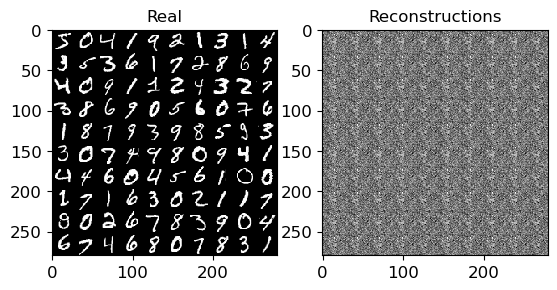

[iter: 1 ]: Training Loss: 0.92
[iter: 2 ]: Training Loss: 0.88
[iter: 3 ]: Training Loss: 0.78
[iter: 4 ]: Training Loss: 0.60
[iter: 5 ]: Training Loss: 0.42
[iter: 6 ]: Training Loss: 0.30
[iter: 7 ]: Training Loss: 0.33
[iter: 8 ]: Training Loss: 0.31
[iter: 9 ]: Training Loss: 0.32
[iter: 10 ]: Training Loss: 0.32
[iter: 11 ]: Training Loss: 0.28
[iter: 12 ]: Training Loss: 0.32
[iter: 13 ]: Training Loss: 0.32
[iter: 14 ]: Training Loss: 0.32
[iter: 15 ]: Training Loss: 0.31
[iter: 16 ]: Training Loss: 0.32
[iter: 17 ]: Training Loss: 0.34
[iter: 18 ]: Training Loss: 0.33
[iter: 19 ]: Training Loss: 0.32
[iter: 20 ]: Training Loss: 0.29
[iter: 21 ]: Training Loss: 0.30
[iter: 22 ]: Training Loss: 0.31
[iter: 23 ]: Training Loss: 0.33
[iter: 24 ]: Training Loss: 0.32
[iter: 25 ]: Training Loss: 0.29
[iter: 26 ]: Training Loss: 0.28
[iter: 27 ]: Training Loss: 0.29
[iter: 28 ]: Training Loss: 0.30
[iter: 29 ]: Training Loss: 0.31
[iter: 30 ]: Training Loss: 0.30
[iter: 31 ]: Traini

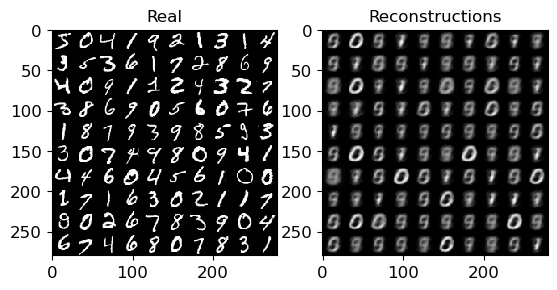

[iter: 201 ]: Training Loss: 0.21
[iter: 202 ]: Training Loss: 0.23
[iter: 203 ]: Training Loss: 0.22
[iter: 204 ]: Training Loss: 0.24
[iter: 205 ]: Training Loss: 0.22
[iter: 206 ]: Training Loss: 0.24
[iter: 207 ]: Training Loss: 0.24
[iter: 208 ]: Training Loss: 0.21
[iter: 209 ]: Training Loss: 0.26
[iter: 210 ]: Training Loss: 0.23
[iter: 211 ]: Training Loss: 0.23
[iter: 212 ]: Training Loss: 0.24
[iter: 213 ]: Training Loss: 0.25
[iter: 214 ]: Training Loss: 0.24
[iter: 215 ]: Training Loss: 0.23
[iter: 216 ]: Training Loss: 0.24
[iter: 217 ]: Training Loss: 0.24
[iter: 218 ]: Training Loss: 0.25
[iter: 219 ]: Training Loss: 0.25
[iter: 220 ]: Training Loss: 0.25
[iter: 221 ]: Training Loss: 0.23
[iter: 222 ]: Training Loss: 0.23
[iter: 223 ]: Training Loss: 0.23
[iter: 224 ]: Training Loss: 0.24
[iter: 225 ]: Training Loss: 0.23
[iter: 226 ]: Training Loss: 0.27
[iter: 227 ]: Training Loss: 0.25
[iter: 228 ]: Training Loss: 0.24
[iter: 229 ]: Training Loss: 0.26
[iter: 230 ]: 

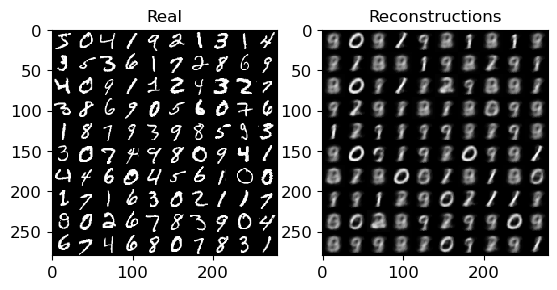

[iter: 401 ]: Training Loss: 0.23
[iter: 402 ]: Training Loss: 0.20
[iter: 403 ]: Training Loss: 0.24
[iter: 404 ]: Training Loss: 0.24
[iter: 405 ]: Training Loss: 0.23
[iter: 406 ]: Training Loss: 0.22
[iter: 407 ]: Training Loss: 0.21
[iter: 408 ]: Training Loss: 0.22
[iter: 409 ]: Training Loss: 0.23
[iter: 410 ]: Training Loss: 0.22
[iter: 411 ]: Training Loss: 0.21
[iter: 412 ]: Training Loss: 0.23
[iter: 413 ]: Training Loss: 0.20
[iter: 414 ]: Training Loss: 0.21
[iter: 415 ]: Training Loss: 0.22
[iter: 416 ]: Training Loss: 0.22
[iter: 417 ]: Training Loss: 0.22
[iter: 418 ]: Training Loss: 0.24
[iter: 419 ]: Training Loss: 0.23
[iter: 420 ]: Training Loss: 0.23
[iter: 421 ]: Training Loss: 0.23
[iter: 422 ]: Training Loss: 0.23
[iter: 423 ]: Training Loss: 0.23
[iter: 424 ]: Training Loss: 0.25
[iter: 425 ]: Training Loss: 0.22
[iter: 426 ]: Training Loss: 0.21
[iter: 427 ]: Training Loss: 0.23
[iter: 428 ]: Training Loss: 0.23
[iter: 429 ]: Training Loss: 0.22
[iter: 430 ]: 

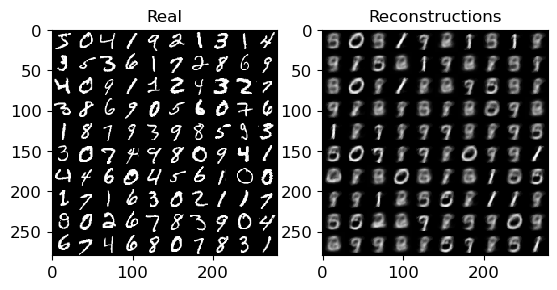

[iter: 601 ]: Training Loss: 0.20
[iter: 602 ]: Training Loss: 0.21
[iter: 603 ]: Training Loss: 0.21
[iter: 604 ]: Training Loss: 0.22
[iter: 605 ]: Training Loss: 0.21
[iter: 606 ]: Training Loss: 0.23
[iter: 607 ]: Training Loss: 0.22
[iter: 608 ]: Training Loss: 0.22
[iter: 609 ]: Training Loss: 0.19
[iter: 610 ]: Training Loss: 0.22
[iter: 611 ]: Training Loss: 0.21
[iter: 612 ]: Training Loss: 0.22
[iter: 613 ]: Training Loss: 0.21
[iter: 614 ]: Training Loss: 0.20
[iter: 615 ]: Training Loss: 0.20
[iter: 616 ]: Training Loss: 0.21
[iter: 617 ]: Training Loss: 0.23
[iter: 618 ]: Training Loss: 0.19
[iter: 619 ]: Training Loss: 0.23
[iter: 620 ]: Training Loss: 0.20
[iter: 621 ]: Training Loss: 0.20
[iter: 622 ]: Training Loss: 0.23
[iter: 623 ]: Training Loss: 0.22
[iter: 624 ]: Training Loss: 0.20
[iter: 625 ]: Training Loss: 0.21
[iter: 626 ]: Training Loss: 0.23
[iter: 627 ]: Training Loss: 0.19
[iter: 628 ]: Training Loss: 0.21
[iter: 629 ]: Training Loss: 0.21
[iter: 630 ]: 

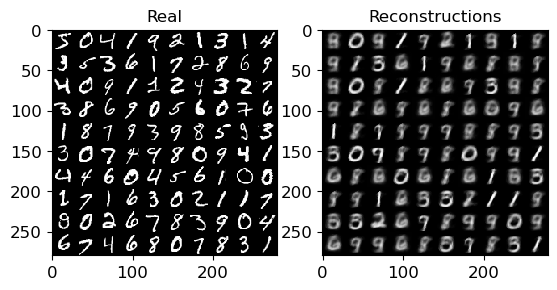

[iter: 801 ]: Training Loss: 0.20
[iter: 802 ]: Training Loss: 0.20
[iter: 803 ]: Training Loss: 0.21
[iter: 804 ]: Training Loss: 0.19
[iter: 805 ]: Training Loss: 0.23
[iter: 806 ]: Training Loss: 0.22
[iter: 807 ]: Training Loss: 0.22
[iter: 808 ]: Training Loss: 0.20
[iter: 809 ]: Training Loss: 0.20
[iter: 810 ]: Training Loss: 0.20
[iter: 811 ]: Training Loss: 0.22
[iter: 812 ]: Training Loss: 0.20
[iter: 813 ]: Training Loss: 0.21
[iter: 814 ]: Training Loss: 0.19
[iter: 815 ]: Training Loss: 0.19
[iter: 816 ]: Training Loss: 0.20
[iter: 817 ]: Training Loss: 0.20
[iter: 818 ]: Training Loss: 0.22
[iter: 819 ]: Training Loss: 0.21
[iter: 820 ]: Training Loss: 0.21
[iter: 821 ]: Training Loss: 0.21
[iter: 822 ]: Training Loss: 0.19
[iter: 823 ]: Training Loss: 0.21
[iter: 824 ]: Training Loss: 0.23
[iter: 825 ]: Training Loss: 0.23
[iter: 826 ]: Training Loss: 0.22
[iter: 827 ]: Training Loss: 0.22
[iter: 828 ]: Training Loss: 0.21
[iter: 829 ]: Training Loss: 0.21
[iter: 830 ]: 

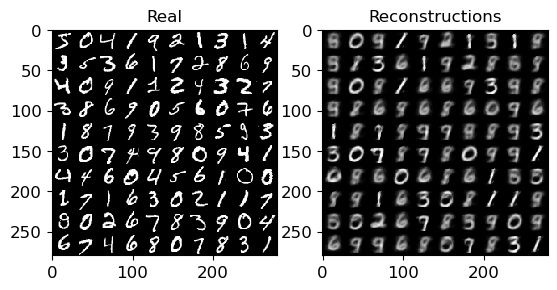

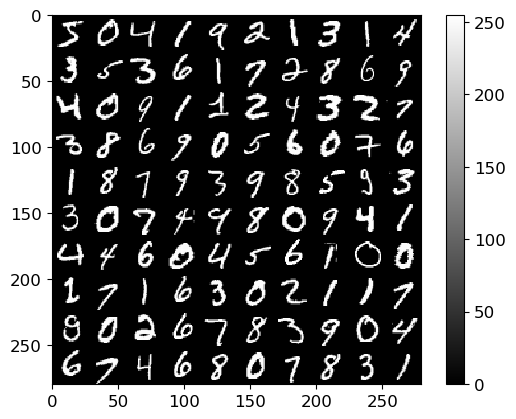

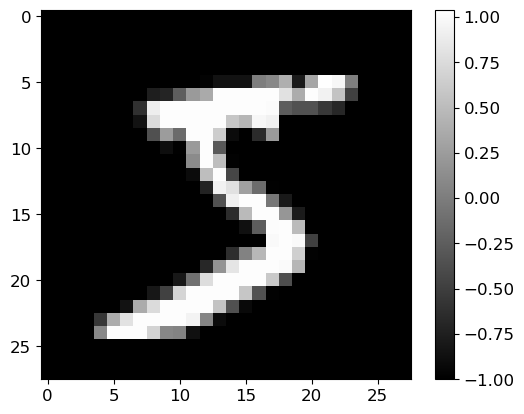

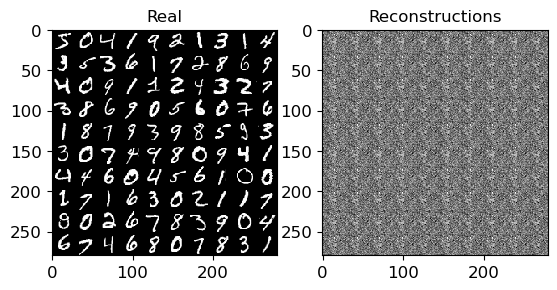

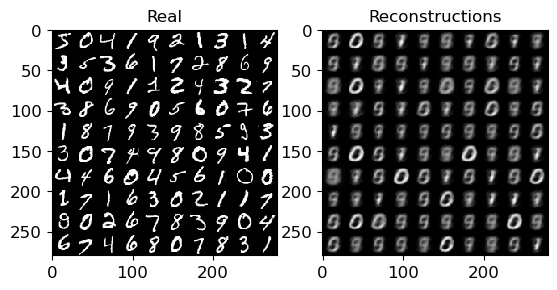

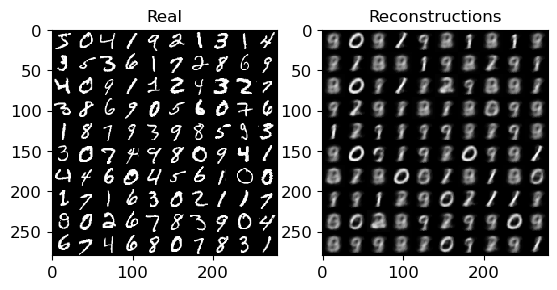

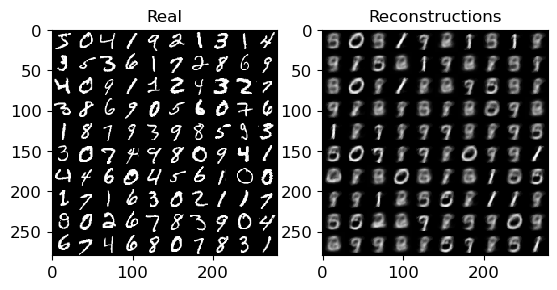

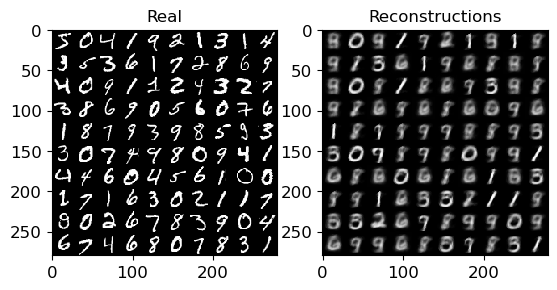

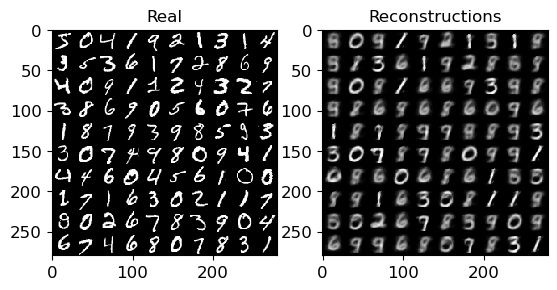

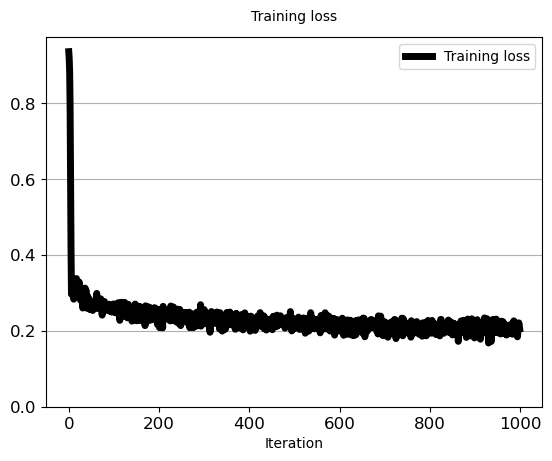

In [25]:
# -*- coding: utf-8 -*-
import torch
import torch.optim as optim
import torch.nn as nn

class Network():
    
    def backward_pass(self, loss):
        # Performs back propagation and computes gradients
        # With PyTorch, we do not need to compute gradients analytically for parameters were requires_grads=True, 
        # Calling loss.backward(), torch's Autograd automatically computes grads of loss wrt each parameter p,...
        # ... and **puts them in p.grad**. Return them in a list.
        loss.backward() #YW: from pytorch 
        grads = [param.grad for param in self.params] #YW: collect the gradients computed during backpropagation for all the parameters of the model.
        #YW: self.params: parameters of the model, These parameters (e.g., weights and biases) are tensors with requires_grad=True
        #YW: .grad: Contains the gradient of the loss with respect to each parameter after backpropagation. Is updated automatically by PyTorch’s autograd engine.
        return grads
    
class Autoencoder(Network):
    #YW: Since the Autoencoder class (child class of Network Class) inherits from the Network class, it has access to all the methods and attributes defined in the Network class, including the backward_pass function. This is a key feature of inheritance in object-oriented programming.

    def __init__(self, rng, D_in, D_hid_enc, D_bottleneck, D_hid_dec):
        # Construct and initialize network parameters
        D_in = D_in # Dimension of input feature-vectors. Length of a vectorised image.
        D_hid_1 = D_hid_enc # Dimension of Encoder's hidden layer, YW: Number of neurons in the first hidden layer.
        D_hid_2 = D_bottleneck # YW: Number of neurons in the bottleneck layer
        D_hid_3 = D_hid_dec  # Dimension of Decoder's hidden layer
        D_out = D_in # Dimension of Output layer.
        
        self.D_bottleneck = D_bottleneck  # Keep track of it, we will need it.
        
        ##### TODO: Initialize the Auto-Encoder's parameters. Also see forward_pass(...)) ########
        # Dimensions of parameter tensors are (number of neurons + 1) per layer, to account for +1 bias.
        # YW: generate random value from normal distribution w mean = 0 and stdv = 0.01 
        w1_init = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, D_hid_1)) 
        w2_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_1+1, D_hid_2))
        w3_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_2+1, D_hid_3))
        w4_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_3+1, D_out))
        # Pytorch tensors, parameters of the model
        # Use the above numpy arrays as of random floats as initialization for the Pytorch weights.
        # YW: convert numpy array to pytorch tensor >> integrate with PyTorch's autograd (automatic differentiation) mechanism.
        w1 = torch.tensor(w1_init, dtype=torch.float, requires_grad=True)
        w2 = torch.tensor(w2_init, dtype=torch.float, requires_grad=True)
        w3 = torch.tensor(w3_init, dtype=torch.float, requires_grad=True)
        w4 = torch.tensor(w4_init, dtype=torch.float, requires_grad=True)
        # Keep track of all trainable parameters:
        self.params = [w1, w2, w3, w4] #YW: the self.params will be used in backward_pass()
        ###########################################################################
        
    def forward_pass(self, batch_imgs):
        # Get parameters
        [w1, w2, w3, w4] = self.params #YW: Unpacks the weights stored in self.params for use in the forward pass.
        
        batch_imgs_t = torch.tensor(batch_imgs, dtype=torch.float)  # Makes pytorch array to pytorch tensor. YW:Converts the input batch_imgs (a NumPy array) into a PyTorch tensor for operations.
        
        unary_feature_for_bias = torch.ones(size=(batch_imgs.shape[0], 1)) # [N, 1] column vector. YW: torch.ones() is a PyTorch function that creates a tensor filled with the value 1.0. N number of rows and each row has 1 column which carries value of 1
        x = torch.cat((batch_imgs_t, unary_feature_for_bias), dim=1) # Extra feature=1 for bias. YW: adding one extra column of 1 
        
        #### TODO: Implement the operations at each layer #####
        # Layer 1
        h1_preact = x.mm(w1) #YW: Matrix multiplication between input x and weight matrix w1.
        h1_act = h1_preact.clamp(min=0) # YW: Applies ReLU activation, min = 0. h1_act output of activation
        # Layer 2 (bottleneck):
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1) #YW: add bias column of 1 
        h2_preact = h1_ext.mm(w2) #YW: matrix multiplication
        h2_act = h2_preact.clamp(min=0)   # <--------- This is the Representation Z
        # Layer 3:
        h2_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        h3_preact = h2_ext.mm(w3)
        h3_act = h3_preact.clamp(min=0)
        # Layer 4 (output):
        h3_ext = torch.cat((h3_act, unary_feature_for_bias), dim=1)
        h4_preact = h3_ext.mm(w4)
        h4_act = torch.tanh(h4_preact)
        # Output layer
        x_pred = h4_act
        #######################################################
        
        ### TODO: Get bottleneck's activations ######
        # Bottleneck actications
        z_code = h2_act
        #############################################
                
        return (x_pred, z_code)
        
        
def reconstruction_loss(x_pred, x_real, eps=1e-7):
    # x_pred: [N, D_out] Prediction returned by forward_pass. Numpy array of shape [N, D_out]
    # x_real: [N, D_in]
    
    # If number array is given, change it to a Torch tensor.
    x_pred = torch.tensor(x_pred, dtype=torch.float) if type(x_pred) is np.ndarray else x_pred
    x_real = torch.tensor(x_real, dtype=torch.float) if type(x_real) is np.ndarray else x_real
    
    ######## TODO: Complete the calculation of Reconstruction loss for each sample ###########
    loss_recon = torch.mean(torch.square(x_pred - x_real), dim=1)
    # YW: dim = 0, 1 mean value of all items, dim = 1 mean by row, dim = 2 mean by column
    ##########################################################################################
    
    cost = torch.mean(loss_recon, dim=0) # Expectation of loss: Mean over samples (axis=0).
    return cost


# Create the network
rng = np.random.RandomState(seed=SEED)
autoencoder_thin = Autoencoder(rng=rng,
                               D_in=H_height*W_width,
                               D_hid_enc=256,
                               D_bottleneck=2,
                               D_hid_dec=256)
# Start training
unsupervised_training_AE(autoencoder_thin,
                         reconstruction_loss,
                         rng,
                         train_imgs_flat,
                         batch_size=40,
                         learning_rate=3e-3,
                         total_iters=1000,
                         iters_per_recon_plot=200)

#def unsupervised_training_AE(net,
#                             loss_func,
#                             rng,
#                             train_imgs_all,
#                             batch_size,
#                             learning_rate,
#                             total_iters,
#                            iters_per_recon_plot=-1):

## Task 3: Encode all training samples in the latent (bottleneck) representation

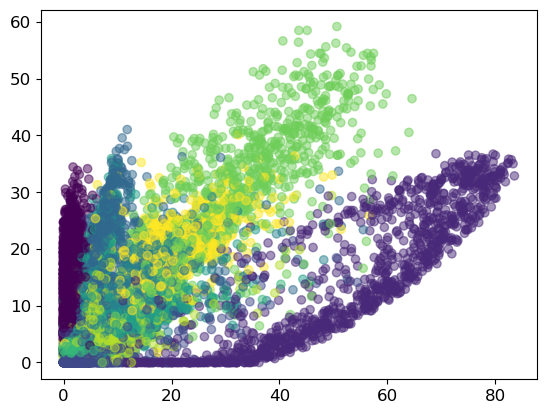

Min Z value per dimension of bottleneck: [0. 0.]
Max Z value per dimension of bottleneck: [83.51495 59.19979]


In [27]:
import matplotlib.pyplot as plt

def encode_and_get_min_max_z(net,
                             imgs_flat,
                             lbls,
                             batch_size,
                             total_iterations=None,
                             plot_2d_embedding=True):
    # This function encodes images, plots the first 2 dimensions of the codes in a plot, and finally...
    # ... returns the minimum and maximum values of the codes for each dimensions of Z.
    # ... We will use  this at a layer task.
    # Arguments:
    # imgs_flat: Numpy array of shape [Number of images, H * W]
    # lbls: Numpy array of shape [number of images], with 1 integer per image. The integer is the class (digit).
    # total_iterations: How many batches to encode. We will use this so that we dont encode and plot ...
    # ... the whoooole training database, because the plot will get cluttered with 60000 points.
    # Returns:
    # min_z: numpy array, vector with [dimensions-of-z] elements. Minimum value per dimension of z.
    # max_z: numpy array, vector with [dimensions-of-z] elements. Maximum value per dimension of z.
    
    # If total iterations is None, the function will just iterate over all data, by breaking them into batches. << make sure all data iterated    
    if total_iterations is None:
        total_iterations = (train_imgs_flat.shape[0] - 1) // batch_size + 1
    
    z_codes_all = []
    lbls_all = []
    for t in range(total_iterations):
        # Sample batch for this SGD iteration
        x_batch = imgs_flat[t*batch_size: (t+1)*batch_size] #YW: Select sample for each batch. exp if batch size = 100, step 1: imgs_flat[0: (0+10*100) = 100], step 2: imgs_flat[100:200] 
        lbls_batch = lbls[t*batch_size: (t+1)*batch_size] 
        
        # Forward pass
        x_pred, z_codes = net.forward_pass(x_batch)

        z_codes_np = z_codes if type(z_codes) is np.ndarray else z_codes.detach().numpy()
        
        z_codes_all.append(z_codes_np)  # List of np.arrays
        lbls_all.append(lbls_batch)
    
    z_codes_all = np.concatenate(z_codes_all)  # Make list of arrays in one array by concatenating along dim=0 (image index) #YW: store latent code, 2 latent code, so 2 columns 
    lbls_all = np.concatenate(lbls_all) #YW: store latent label 
    
    if plot_2d_embedding:
        # Plot the codes with different color per class in a scatter plot:
        plt.scatter(z_codes_all[:,0], z_codes_all[:,1], c=lbls_all, alpha=0.5)  # Plot the first 2 dimensions. YW: different colour by class
        plt.show()
    
    # Get the minimum and maximum values of z per dimension (neuron) of Z. We will use this at a later task
    min_z = np.min(z_codes_all, axis=0)  # min and max for each dimension of z, over all samples.
    max_z = np.max(z_codes_all, axis=0)  # Numpy array (vector) of shape [number of z dimensions]
    
    return min_z, max_z


# Encode training samples, and get the min and max values of the z codes (for each dimension)
min_z, max_z = encode_and_get_min_max_z(autoencoder_thin,
                                        train_imgs_flat,
                                        train_lbls,
                                        batch_size=100,
                                        total_iterations=100)
print("Min Z value per dimension of bottleneck:", min_z)
print("Max Z value per dimension of bottleneck:", max_z)


## Task 4: Train an Auto-Encoder with a larger bottleneck layer

[iter: 0 ]: Training Loss: 0.94


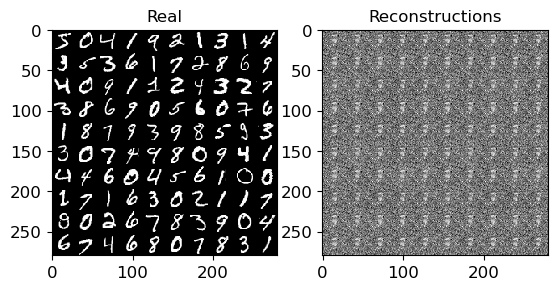

[iter: 1 ]: Training Loss: 0.91
[iter: 2 ]: Training Loss: 0.81
[iter: 3 ]: Training Loss: 0.58
[iter: 4 ]: Training Loss: 0.36
[iter: 5 ]: Training Loss: 0.32
[iter: 6 ]: Training Loss: 0.34
[iter: 7 ]: Training Loss: 0.34
[iter: 8 ]: Training Loss: 0.33
[iter: 9 ]: Training Loss: 0.38
[iter: 10 ]: Training Loss: 0.36
[iter: 11 ]: Training Loss: 0.32
[iter: 12 ]: Training Loss: 0.34
[iter: 13 ]: Training Loss: 0.33
[iter: 14 ]: Training Loss: 0.37
[iter: 15 ]: Training Loss: 0.35
[iter: 16 ]: Training Loss: 0.34
[iter: 17 ]: Training Loss: 0.35
[iter: 18 ]: Training Loss: 0.32
[iter: 19 ]: Training Loss: 0.30
[iter: 20 ]: Training Loss: 0.32
[iter: 21 ]: Training Loss: 0.29
[iter: 22 ]: Training Loss: 0.30
[iter: 23 ]: Training Loss: 0.32
[iter: 24 ]: Training Loss: 0.32
[iter: 25 ]: Training Loss: 0.29
[iter: 26 ]: Training Loss: 0.30
[iter: 27 ]: Training Loss: 0.27
[iter: 28 ]: Training Loss: 0.30
[iter: 29 ]: Training Loss: 0.26
[iter: 30 ]: Training Loss: 0.30
[iter: 31 ]: Traini

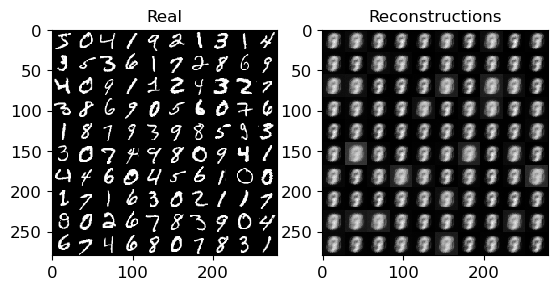

[iter: 51 ]: Training Loss: 0.26
[iter: 52 ]: Training Loss: 0.28
[iter: 53 ]: Training Loss: 0.28
[iter: 54 ]: Training Loss: 0.25
[iter: 55 ]: Training Loss: 0.27
[iter: 56 ]: Training Loss: 0.27
[iter: 57 ]: Training Loss: 0.27
[iter: 58 ]: Training Loss: 0.28
[iter: 59 ]: Training Loss: 0.28
[iter: 60 ]: Training Loss: 0.26
[iter: 61 ]: Training Loss: 0.28
[iter: 62 ]: Training Loss: 0.27
[iter: 63 ]: Training Loss: 0.26
[iter: 64 ]: Training Loss: 0.28
[iter: 65 ]: Training Loss: 0.28
[iter: 66 ]: Training Loss: 0.26
[iter: 67 ]: Training Loss: 0.27
[iter: 68 ]: Training Loss: 0.26
[iter: 69 ]: Training Loss: 0.25
[iter: 70 ]: Training Loss: 0.28
[iter: 71 ]: Training Loss: 0.28
[iter: 72 ]: Training Loss: 0.25
[iter: 73 ]: Training Loss: 0.26
[iter: 74 ]: Training Loss: 0.27
[iter: 75 ]: Training Loss: 0.27
[iter: 76 ]: Training Loss: 0.25
[iter: 77 ]: Training Loss: 0.26
[iter: 78 ]: Training Loss: 0.27
[iter: 79 ]: Training Loss: 0.27
[iter: 80 ]: Training Loss: 0.27
[iter: 81 

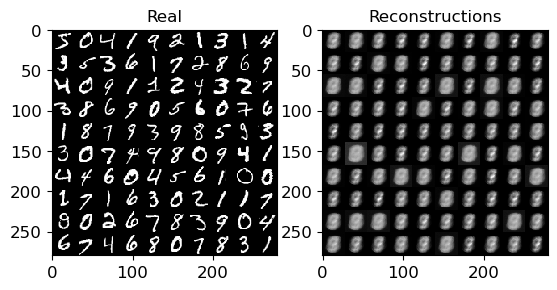

[iter: 101 ]: Training Loss: 0.27
[iter: 102 ]: Training Loss: 0.27
[iter: 103 ]: Training Loss: 0.27
[iter: 104 ]: Training Loss: 0.25
[iter: 105 ]: Training Loss: 0.28
[iter: 106 ]: Training Loss: 0.26
[iter: 107 ]: Training Loss: 0.25
[iter: 108 ]: Training Loss: 0.27
[iter: 109 ]: Training Loss: 0.26
[iter: 110 ]: Training Loss: 0.26
[iter: 111 ]: Training Loss: 0.26
[iter: 112 ]: Training Loss: 0.28
[iter: 113 ]: Training Loss: 0.24
[iter: 114 ]: Training Loss: 0.28
[iter: 115 ]: Training Loss: 0.27
[iter: 116 ]: Training Loss: 0.25
[iter: 117 ]: Training Loss: 0.25
[iter: 118 ]: Training Loss: 0.25
[iter: 119 ]: Training Loss: 0.25
[iter: 120 ]: Training Loss: 0.26
[iter: 121 ]: Training Loss: 0.25
[iter: 122 ]: Training Loss: 0.24
[iter: 123 ]: Training Loss: 0.28
[iter: 124 ]: Training Loss: 0.27
[iter: 125 ]: Training Loss: 0.27
[iter: 126 ]: Training Loss: 0.25
[iter: 127 ]: Training Loss: 0.27
[iter: 128 ]: Training Loss: 0.24
[iter: 129 ]: Training Loss: 0.28
[iter: 130 ]: 

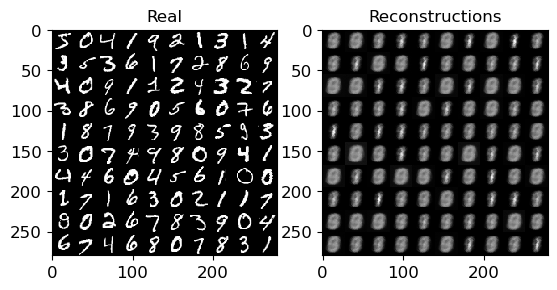

[iter: 151 ]: Training Loss: 0.26
[iter: 152 ]: Training Loss: 0.28
[iter: 153 ]: Training Loss: 0.26
[iter: 154 ]: Training Loss: 0.27
[iter: 155 ]: Training Loss: 0.26
[iter: 156 ]: Training Loss: 0.24
[iter: 157 ]: Training Loss: 0.24
[iter: 158 ]: Training Loss: 0.26
[iter: 159 ]: Training Loss: 0.27
[iter: 160 ]: Training Loss: 0.25
[iter: 161 ]: Training Loss: 0.26
[iter: 162 ]: Training Loss: 0.25
[iter: 163 ]: Training Loss: 0.25
[iter: 164 ]: Training Loss: 0.24
[iter: 165 ]: Training Loss: 0.26
[iter: 166 ]: Training Loss: 0.25
[iter: 167 ]: Training Loss: 0.27
[iter: 168 ]: Training Loss: 0.26
[iter: 169 ]: Training Loss: 0.23
[iter: 170 ]: Training Loss: 0.24
[iter: 171 ]: Training Loss: 0.26
[iter: 172 ]: Training Loss: 0.24
[iter: 173 ]: Training Loss: 0.26
[iter: 174 ]: Training Loss: 0.25
[iter: 175 ]: Training Loss: 0.23
[iter: 176 ]: Training Loss: 0.24
[iter: 177 ]: Training Loss: 0.26
[iter: 178 ]: Training Loss: 0.23
[iter: 179 ]: Training Loss: 0.25
[iter: 180 ]: 

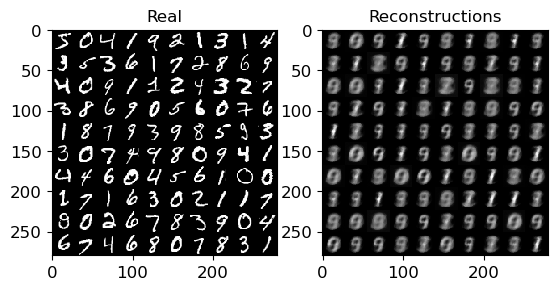

[iter: 201 ]: Training Loss: 0.24
[iter: 202 ]: Training Loss: 0.24
[iter: 203 ]: Training Loss: 0.23
[iter: 204 ]: Training Loss: 0.25
[iter: 205 ]: Training Loss: 0.24
[iter: 206 ]: Training Loss: 0.25
[iter: 207 ]: Training Loss: 0.26
[iter: 208 ]: Training Loss: 0.26
[iter: 209 ]: Training Loss: 0.23
[iter: 210 ]: Training Loss: 0.23
[iter: 211 ]: Training Loss: 0.23
[iter: 212 ]: Training Loss: 0.24
[iter: 213 ]: Training Loss: 0.25
[iter: 214 ]: Training Loss: 0.24
[iter: 215 ]: Training Loss: 0.26
[iter: 216 ]: Training Loss: 0.23
[iter: 217 ]: Training Loss: 0.23
[iter: 218 ]: Training Loss: 0.23
[iter: 219 ]: Training Loss: 0.22
[iter: 220 ]: Training Loss: 0.26
[iter: 221 ]: Training Loss: 0.23
[iter: 222 ]: Training Loss: 0.26
[iter: 223 ]: Training Loss: 0.25
[iter: 224 ]: Training Loss: 0.23
[iter: 225 ]: Training Loss: 0.24
[iter: 226 ]: Training Loss: 0.23
[iter: 227 ]: Training Loss: 0.25
[iter: 228 ]: Training Loss: 0.23
[iter: 229 ]: Training Loss: 0.22
[iter: 230 ]: 

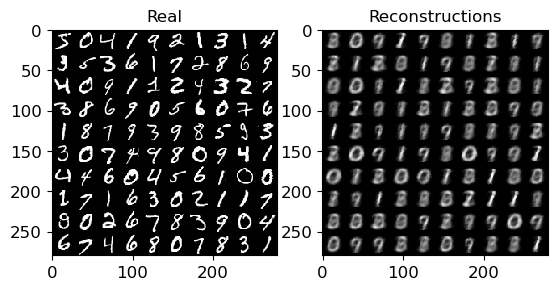

[iter: 251 ]: Training Loss: 0.22
[iter: 252 ]: Training Loss: 0.22
[iter: 253 ]: Training Loss: 0.22
[iter: 254 ]: Training Loss: 0.24
[iter: 255 ]: Training Loss: 0.22
[iter: 256 ]: Training Loss: 0.20
[iter: 257 ]: Training Loss: 0.22
[iter: 258 ]: Training Loss: 0.20
[iter: 259 ]: Training Loss: 0.23
[iter: 260 ]: Training Loss: 0.23
[iter: 261 ]: Training Loss: 0.23
[iter: 262 ]: Training Loss: 0.24
[iter: 263 ]: Training Loss: 0.23
[iter: 264 ]: Training Loss: 0.23
[iter: 265 ]: Training Loss: 0.21
[iter: 266 ]: Training Loss: 0.22
[iter: 267 ]: Training Loss: 0.23
[iter: 268 ]: Training Loss: 0.22
[iter: 269 ]: Training Loss: 0.23
[iter: 270 ]: Training Loss: 0.23
[iter: 271 ]: Training Loss: 0.21
[iter: 272 ]: Training Loss: 0.22
[iter: 273 ]: Training Loss: 0.23
[iter: 274 ]: Training Loss: 0.21
[iter: 275 ]: Training Loss: 0.24
[iter: 276 ]: Training Loss: 0.22
[iter: 277 ]: Training Loss: 0.20
[iter: 278 ]: Training Loss: 0.22
[iter: 279 ]: Training Loss: 0.24
[iter: 280 ]: 

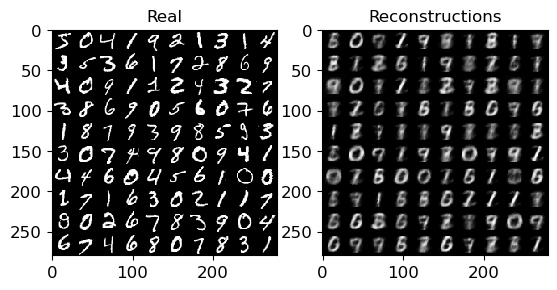

[iter: 301 ]: Training Loss: 0.19
[iter: 302 ]: Training Loss: 0.18
[iter: 303 ]: Training Loss: 0.21
[iter: 304 ]: Training Loss: 0.21
[iter: 305 ]: Training Loss: 0.21
[iter: 306 ]: Training Loss: 0.21
[iter: 307 ]: Training Loss: 0.21
[iter: 308 ]: Training Loss: 0.20
[iter: 309 ]: Training Loss: 0.20
[iter: 310 ]: Training Loss: 0.21
[iter: 311 ]: Training Loss: 0.21
[iter: 312 ]: Training Loss: 0.22
[iter: 313 ]: Training Loss: 0.19
[iter: 314 ]: Training Loss: 0.21
[iter: 315 ]: Training Loss: 0.22
[iter: 316 ]: Training Loss: 0.20
[iter: 317 ]: Training Loss: 0.21
[iter: 318 ]: Training Loss: 0.21
[iter: 319 ]: Training Loss: 0.22
[iter: 320 ]: Training Loss: 0.19
[iter: 321 ]: Training Loss: 0.22
[iter: 322 ]: Training Loss: 0.20
[iter: 323 ]: Training Loss: 0.22
[iter: 324 ]: Training Loss: 0.21
[iter: 325 ]: Training Loss: 0.21
[iter: 326 ]: Training Loss: 0.20
[iter: 327 ]: Training Loss: 0.20
[iter: 328 ]: Training Loss: 0.20
[iter: 329 ]: Training Loss: 0.20
[iter: 330 ]: 

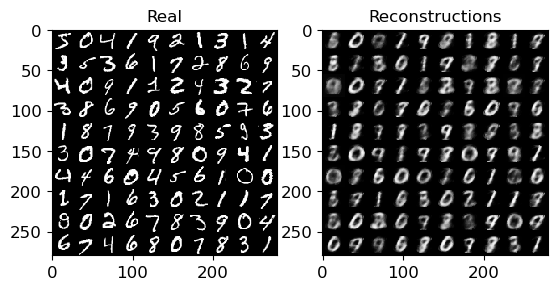

[iter: 351 ]: Training Loss: 0.20
[iter: 352 ]: Training Loss: 0.16
[iter: 353 ]: Training Loss: 0.17
[iter: 354 ]: Training Loss: 0.19
[iter: 355 ]: Training Loss: 0.20
[iter: 356 ]: Training Loss: 0.19
[iter: 357 ]: Training Loss: 0.19
[iter: 358 ]: Training Loss: 0.17
[iter: 359 ]: Training Loss: 0.17
[iter: 360 ]: Training Loss: 0.19
[iter: 361 ]: Training Loss: 0.18
[iter: 362 ]: Training Loss: 0.18
[iter: 363 ]: Training Loss: 0.19
[iter: 364 ]: Training Loss: 0.19
[iter: 365 ]: Training Loss: 0.18
[iter: 366 ]: Training Loss: 0.18
[iter: 367 ]: Training Loss: 0.18
[iter: 368 ]: Training Loss: 0.19
[iter: 369 ]: Training Loss: 0.18
[iter: 370 ]: Training Loss: 0.19
[iter: 371 ]: Training Loss: 0.19
[iter: 372 ]: Training Loss: 0.17
[iter: 373 ]: Training Loss: 0.18
[iter: 374 ]: Training Loss: 0.19
[iter: 375 ]: Training Loss: 0.18
[iter: 376 ]: Training Loss: 0.19
[iter: 377 ]: Training Loss: 0.16
[iter: 378 ]: Training Loss: 0.16
[iter: 379 ]: Training Loss: 0.17
[iter: 380 ]: 

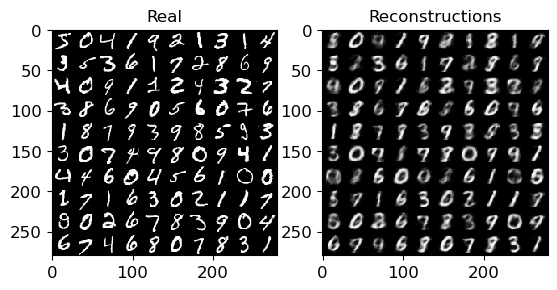

[iter: 401 ]: Training Loss: 0.17
[iter: 402 ]: Training Loss: 0.17
[iter: 403 ]: Training Loss: 0.18
[iter: 404 ]: Training Loss: 0.18
[iter: 405 ]: Training Loss: 0.16
[iter: 406 ]: Training Loss: 0.17
[iter: 407 ]: Training Loss: 0.16
[iter: 408 ]: Training Loss: 0.18
[iter: 409 ]: Training Loss: 0.17
[iter: 410 ]: Training Loss: 0.16
[iter: 411 ]: Training Loss: 0.16
[iter: 412 ]: Training Loss: 0.17
[iter: 413 ]: Training Loss: 0.16
[iter: 414 ]: Training Loss: 0.18
[iter: 415 ]: Training Loss: 0.16
[iter: 416 ]: Training Loss: 0.17
[iter: 417 ]: Training Loss: 0.18
[iter: 418 ]: Training Loss: 0.17
[iter: 419 ]: Training Loss: 0.15
[iter: 420 ]: Training Loss: 0.17
[iter: 421 ]: Training Loss: 0.16
[iter: 422 ]: Training Loss: 0.16
[iter: 423 ]: Training Loss: 0.17
[iter: 424 ]: Training Loss: 0.16
[iter: 425 ]: Training Loss: 0.16
[iter: 426 ]: Training Loss: 0.15
[iter: 427 ]: Training Loss: 0.16
[iter: 428 ]: Training Loss: 0.14
[iter: 429 ]: Training Loss: 0.15
[iter: 430 ]: 

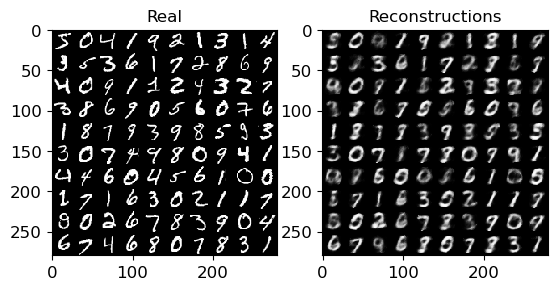

[iter: 451 ]: Training Loss: 0.16
[iter: 452 ]: Training Loss: 0.15
[iter: 453 ]: Training Loss: 0.14
[iter: 454 ]: Training Loss: 0.15
[iter: 455 ]: Training Loss: 0.15
[iter: 456 ]: Training Loss: 0.17
[iter: 457 ]: Training Loss: 0.16
[iter: 458 ]: Training Loss: 0.16
[iter: 459 ]: Training Loss: 0.14
[iter: 460 ]: Training Loss: 0.15
[iter: 461 ]: Training Loss: 0.14
[iter: 462 ]: Training Loss: 0.16
[iter: 463 ]: Training Loss: 0.15
[iter: 464 ]: Training Loss: 0.15
[iter: 465 ]: Training Loss: 0.14
[iter: 466 ]: Training Loss: 0.15
[iter: 467 ]: Training Loss: 0.14
[iter: 468 ]: Training Loss: 0.15
[iter: 469 ]: Training Loss: 0.15
[iter: 470 ]: Training Loss: 0.14
[iter: 471 ]: Training Loss: 0.14
[iter: 472 ]: Training Loss: 0.14
[iter: 473 ]: Training Loss: 0.13
[iter: 474 ]: Training Loss: 0.16
[iter: 475 ]: Training Loss: 0.13
[iter: 476 ]: Training Loss: 0.16
[iter: 477 ]: Training Loss: 0.15
[iter: 478 ]: Training Loss: 0.16
[iter: 479 ]: Training Loss: 0.16
[iter: 480 ]: 

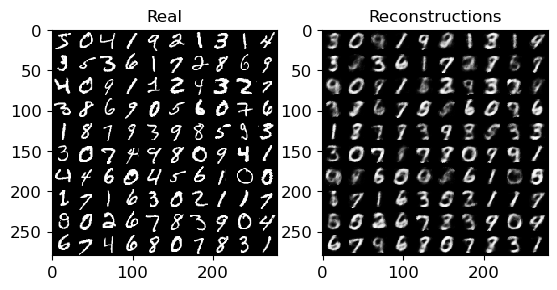

[iter: 501 ]: Training Loss: 0.15
[iter: 502 ]: Training Loss: 0.15
[iter: 503 ]: Training Loss: 0.17
[iter: 504 ]: Training Loss: 0.13
[iter: 505 ]: Training Loss: 0.14
[iter: 506 ]: Training Loss: 0.15
[iter: 507 ]: Training Loss: 0.14
[iter: 508 ]: Training Loss: 0.13
[iter: 509 ]: Training Loss: 0.14
[iter: 510 ]: Training Loss: 0.15
[iter: 511 ]: Training Loss: 0.14
[iter: 512 ]: Training Loss: 0.15
[iter: 513 ]: Training Loss: 0.16
[iter: 514 ]: Training Loss: 0.13
[iter: 515 ]: Training Loss: 0.15
[iter: 516 ]: Training Loss: 0.14
[iter: 517 ]: Training Loss: 0.15
[iter: 518 ]: Training Loss: 0.15
[iter: 519 ]: Training Loss: 0.15
[iter: 520 ]: Training Loss: 0.14
[iter: 521 ]: Training Loss: 0.14
[iter: 522 ]: Training Loss: 0.14
[iter: 523 ]: Training Loss: 0.14
[iter: 524 ]: Training Loss: 0.16
[iter: 525 ]: Training Loss: 0.15
[iter: 526 ]: Training Loss: 0.14
[iter: 527 ]: Training Loss: 0.13
[iter: 528 ]: Training Loss: 0.14
[iter: 529 ]: Training Loss: 0.14
[iter: 530 ]: 

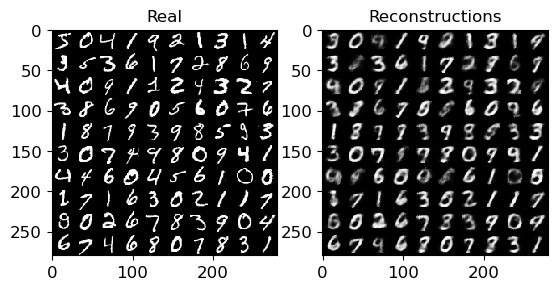

[iter: 551 ]: Training Loss: 0.13
[iter: 552 ]: Training Loss: 0.13
[iter: 553 ]: Training Loss: 0.12
[iter: 554 ]: Training Loss: 0.15
[iter: 555 ]: Training Loss: 0.14
[iter: 556 ]: Training Loss: 0.13
[iter: 557 ]: Training Loss: 0.15
[iter: 558 ]: Training Loss: 0.13
[iter: 559 ]: Training Loss: 0.13
[iter: 560 ]: Training Loss: 0.13
[iter: 561 ]: Training Loss: 0.14
[iter: 562 ]: Training Loss: 0.13
[iter: 563 ]: Training Loss: 0.13
[iter: 564 ]: Training Loss: 0.14
[iter: 565 ]: Training Loss: 0.13
[iter: 566 ]: Training Loss: 0.14
[iter: 567 ]: Training Loss: 0.14
[iter: 568 ]: Training Loss: 0.14
[iter: 569 ]: Training Loss: 0.12
[iter: 570 ]: Training Loss: 0.13
[iter: 571 ]: Training Loss: 0.14
[iter: 572 ]: Training Loss: 0.12
[iter: 573 ]: Training Loss: 0.14
[iter: 574 ]: Training Loss: 0.13
[iter: 575 ]: Training Loss: 0.14
[iter: 576 ]: Training Loss: 0.13
[iter: 577 ]: Training Loss: 0.12
[iter: 578 ]: Training Loss: 0.14
[iter: 579 ]: Training Loss: 0.14
[iter: 580 ]: 

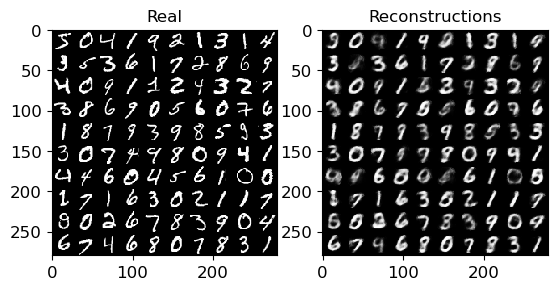

[iter: 601 ]: Training Loss: 0.15
[iter: 602 ]: Training Loss: 0.14
[iter: 603 ]: Training Loss: 0.14
[iter: 604 ]: Training Loss: 0.12
[iter: 605 ]: Training Loss: 0.12
[iter: 606 ]: Training Loss: 0.15
[iter: 607 ]: Training Loss: 0.14
[iter: 608 ]: Training Loss: 0.12
[iter: 609 ]: Training Loss: 0.13
[iter: 610 ]: Training Loss: 0.13
[iter: 611 ]: Training Loss: 0.13
[iter: 612 ]: Training Loss: 0.14
[iter: 613 ]: Training Loss: 0.12
[iter: 614 ]: Training Loss: 0.14
[iter: 615 ]: Training Loss: 0.14
[iter: 616 ]: Training Loss: 0.13
[iter: 617 ]: Training Loss: 0.12
[iter: 618 ]: Training Loss: 0.12
[iter: 619 ]: Training Loss: 0.13
[iter: 620 ]: Training Loss: 0.13
[iter: 621 ]: Training Loss: 0.12
[iter: 622 ]: Training Loss: 0.11
[iter: 623 ]: Training Loss: 0.12
[iter: 624 ]: Training Loss: 0.14
[iter: 625 ]: Training Loss: 0.12
[iter: 626 ]: Training Loss: 0.12
[iter: 627 ]: Training Loss: 0.11
[iter: 628 ]: Training Loss: 0.12
[iter: 629 ]: Training Loss: 0.13
[iter: 630 ]: 

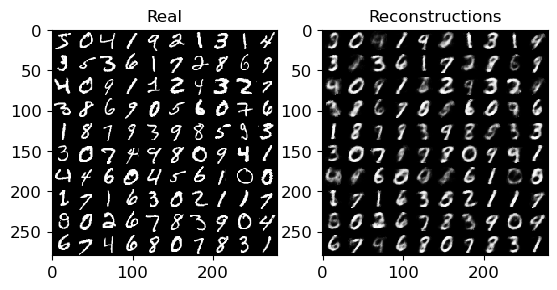

[iter: 651 ]: Training Loss: 0.12
[iter: 652 ]: Training Loss: 0.11
[iter: 653 ]: Training Loss: 0.13
[iter: 654 ]: Training Loss: 0.14
[iter: 655 ]: Training Loss: 0.13
[iter: 656 ]: Training Loss: 0.13
[iter: 657 ]: Training Loss: 0.12
[iter: 658 ]: Training Loss: 0.14
[iter: 659 ]: Training Loss: 0.14
[iter: 660 ]: Training Loss: 0.11
[iter: 661 ]: Training Loss: 0.12
[iter: 662 ]: Training Loss: 0.14
[iter: 663 ]: Training Loss: 0.14
[iter: 664 ]: Training Loss: 0.13
[iter: 665 ]: Training Loss: 0.13
[iter: 666 ]: Training Loss: 0.13
[iter: 667 ]: Training Loss: 0.12
[iter: 668 ]: Training Loss: 0.12
[iter: 669 ]: Training Loss: 0.12
[iter: 670 ]: Training Loss: 0.13
[iter: 671 ]: Training Loss: 0.11
[iter: 672 ]: Training Loss: 0.12
[iter: 673 ]: Training Loss: 0.13
[iter: 674 ]: Training Loss: 0.13
[iter: 675 ]: Training Loss: 0.13
[iter: 676 ]: Training Loss: 0.13
[iter: 677 ]: Training Loss: 0.12
[iter: 678 ]: Training Loss: 0.11
[iter: 679 ]: Training Loss: 0.12
[iter: 680 ]: 

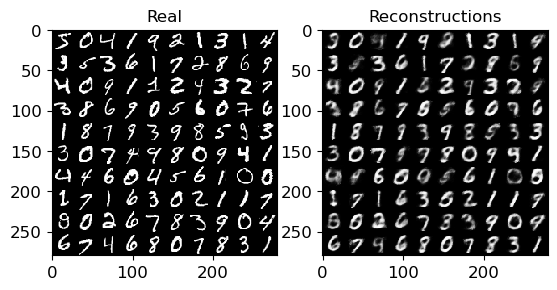

[iter: 701 ]: Training Loss: 0.11
[iter: 702 ]: Training Loss: 0.13
[iter: 703 ]: Training Loss: 0.12
[iter: 704 ]: Training Loss: 0.11
[iter: 705 ]: Training Loss: 0.12
[iter: 706 ]: Training Loss: 0.11
[iter: 707 ]: Training Loss: 0.12
[iter: 708 ]: Training Loss: 0.12
[iter: 709 ]: Training Loss: 0.12
[iter: 710 ]: Training Loss: 0.12
[iter: 711 ]: Training Loss: 0.11
[iter: 712 ]: Training Loss: 0.13
[iter: 713 ]: Training Loss: 0.12
[iter: 714 ]: Training Loss: 0.12
[iter: 715 ]: Training Loss: 0.11
[iter: 716 ]: Training Loss: 0.11
[iter: 717 ]: Training Loss: 0.11
[iter: 718 ]: Training Loss: 0.12
[iter: 719 ]: Training Loss: 0.12
[iter: 720 ]: Training Loss: 0.12
[iter: 721 ]: Training Loss: 0.11
[iter: 722 ]: Training Loss: 0.12
[iter: 723 ]: Training Loss: 0.12
[iter: 724 ]: Training Loss: 0.13
[iter: 725 ]: Training Loss: 0.12
[iter: 726 ]: Training Loss: 0.12
[iter: 727 ]: Training Loss: 0.13
[iter: 728 ]: Training Loss: 0.13
[iter: 729 ]: Training Loss: 0.12
[iter: 730 ]: 

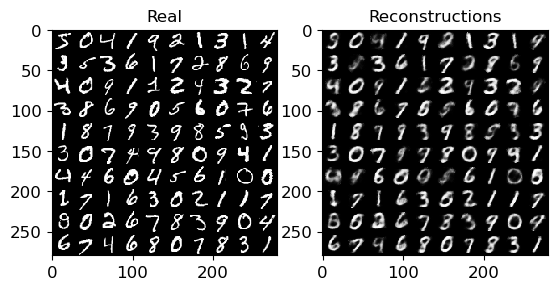

[iter: 751 ]: Training Loss: 0.13
[iter: 752 ]: Training Loss: 0.12
[iter: 753 ]: Training Loss: 0.12
[iter: 754 ]: Training Loss: 0.10
[iter: 755 ]: Training Loss: 0.12
[iter: 756 ]: Training Loss: 0.11
[iter: 757 ]: Training Loss: 0.12
[iter: 758 ]: Training Loss: 0.12
[iter: 759 ]: Training Loss: 0.11
[iter: 760 ]: Training Loss: 0.11
[iter: 761 ]: Training Loss: 0.12
[iter: 762 ]: Training Loss: 0.11
[iter: 763 ]: Training Loss: 0.11
[iter: 764 ]: Training Loss: 0.11
[iter: 765 ]: Training Loss: 0.10
[iter: 766 ]: Training Loss: 0.13
[iter: 767 ]: Training Loss: 0.12
[iter: 768 ]: Training Loss: 0.14
[iter: 769 ]: Training Loss: 0.12
[iter: 770 ]: Training Loss: 0.11
[iter: 771 ]: Training Loss: 0.12
[iter: 772 ]: Training Loss: 0.12
[iter: 773 ]: Training Loss: 0.11
[iter: 774 ]: Training Loss: 0.11
[iter: 775 ]: Training Loss: 0.09
[iter: 776 ]: Training Loss: 0.11
[iter: 777 ]: Training Loss: 0.12
[iter: 778 ]: Training Loss: 0.10
[iter: 779 ]: Training Loss: 0.11
[iter: 780 ]: 

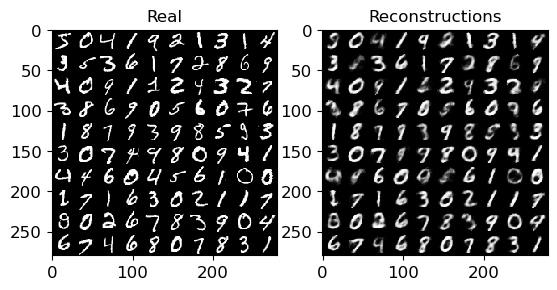

[iter: 801 ]: Training Loss: 0.10
[iter: 802 ]: Training Loss: 0.11
[iter: 803 ]: Training Loss: 0.10
[iter: 804 ]: Training Loss: 0.11
[iter: 805 ]: Training Loss: 0.12
[iter: 806 ]: Training Loss: 0.12
[iter: 807 ]: Training Loss: 0.11
[iter: 808 ]: Training Loss: 0.11
[iter: 809 ]: Training Loss: 0.10
[iter: 810 ]: Training Loss: 0.12
[iter: 811 ]: Training Loss: 0.11
[iter: 812 ]: Training Loss: 0.12
[iter: 813 ]: Training Loss: 0.10
[iter: 814 ]: Training Loss: 0.12
[iter: 815 ]: Training Loss: 0.11
[iter: 816 ]: Training Loss: 0.11
[iter: 817 ]: Training Loss: 0.11
[iter: 818 ]: Training Loss: 0.11
[iter: 819 ]: Training Loss: 0.12
[iter: 820 ]: Training Loss: 0.12
[iter: 821 ]: Training Loss: 0.12
[iter: 822 ]: Training Loss: 0.11
[iter: 823 ]: Training Loss: 0.09
[iter: 824 ]: Training Loss: 0.10
[iter: 825 ]: Training Loss: 0.10
[iter: 826 ]: Training Loss: 0.11
[iter: 827 ]: Training Loss: 0.12
[iter: 828 ]: Training Loss: 0.11
[iter: 829 ]: Training Loss: 0.13
[iter: 830 ]: 

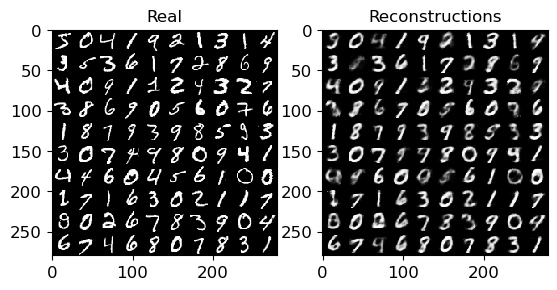

[iter: 851 ]: Training Loss: 0.12
[iter: 852 ]: Training Loss: 0.12
[iter: 853 ]: Training Loss: 0.12
[iter: 854 ]: Training Loss: 0.12
[iter: 855 ]: Training Loss: 0.09
[iter: 856 ]: Training Loss: 0.11
[iter: 857 ]: Training Loss: 0.11
[iter: 858 ]: Training Loss: 0.11
[iter: 859 ]: Training Loss: 0.11
[iter: 860 ]: Training Loss: 0.12
[iter: 861 ]: Training Loss: 0.12
[iter: 862 ]: Training Loss: 0.14
[iter: 863 ]: Training Loss: 0.12
[iter: 864 ]: Training Loss: 0.10
[iter: 865 ]: Training Loss: 0.12
[iter: 866 ]: Training Loss: 0.11
[iter: 867 ]: Training Loss: 0.11
[iter: 868 ]: Training Loss: 0.10
[iter: 869 ]: Training Loss: 0.11
[iter: 870 ]: Training Loss: 0.12
[iter: 871 ]: Training Loss: 0.10
[iter: 872 ]: Training Loss: 0.10
[iter: 873 ]: Training Loss: 0.11
[iter: 874 ]: Training Loss: 0.10
[iter: 875 ]: Training Loss: 0.10
[iter: 876 ]: Training Loss: 0.10
[iter: 877 ]: Training Loss: 0.10
[iter: 878 ]: Training Loss: 0.11
[iter: 879 ]: Training Loss: 0.12
[iter: 880 ]: 

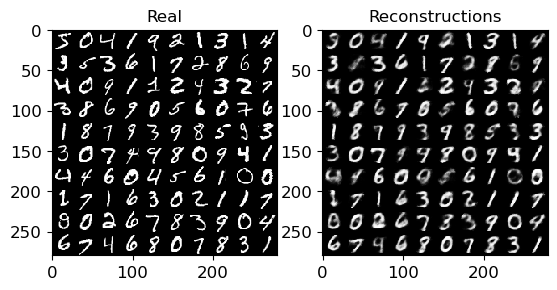

[iter: 901 ]: Training Loss: 0.10
[iter: 902 ]: Training Loss: 0.11
[iter: 903 ]: Training Loss: 0.11
[iter: 904 ]: Training Loss: 0.13
[iter: 905 ]: Training Loss: 0.12
[iter: 906 ]: Training Loss: 0.11
[iter: 907 ]: Training Loss: 0.10
[iter: 908 ]: Training Loss: 0.11
[iter: 909 ]: Training Loss: 0.10
[iter: 910 ]: Training Loss: 0.12
[iter: 911 ]: Training Loss: 0.11
[iter: 912 ]: Training Loss: 0.10
[iter: 913 ]: Training Loss: 0.12
[iter: 914 ]: Training Loss: 0.12
[iter: 915 ]: Training Loss: 0.11
[iter: 916 ]: Training Loss: 0.11
[iter: 917 ]: Training Loss: 0.09
[iter: 918 ]: Training Loss: 0.10
[iter: 919 ]: Training Loss: 0.11
[iter: 920 ]: Training Loss: 0.12
[iter: 921 ]: Training Loss: 0.10
[iter: 922 ]: Training Loss: 0.11
[iter: 923 ]: Training Loss: 0.11
[iter: 924 ]: Training Loss: 0.11
[iter: 925 ]: Training Loss: 0.11
[iter: 926 ]: Training Loss: 0.10
[iter: 927 ]: Training Loss: 0.11
[iter: 928 ]: Training Loss: 0.09
[iter: 929 ]: Training Loss: 0.11
[iter: 930 ]: 

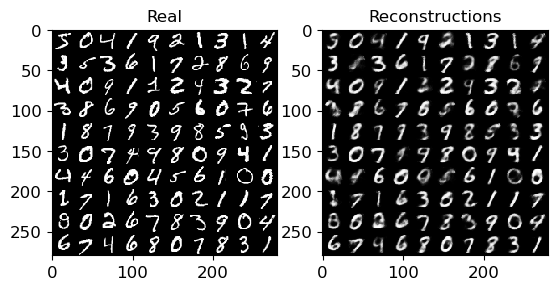

[iter: 951 ]: Training Loss: 0.10
[iter: 952 ]: Training Loss: 0.11
[iter: 953 ]: Training Loss: 0.10
[iter: 954 ]: Training Loss: 0.10
[iter: 955 ]: Training Loss: 0.12
[iter: 956 ]: Training Loss: 0.10
[iter: 957 ]: Training Loss: 0.13
[iter: 958 ]: Training Loss: 0.11
[iter: 959 ]: Training Loss: 0.10
[iter: 960 ]: Training Loss: 0.11
[iter: 961 ]: Training Loss: 0.10
[iter: 962 ]: Training Loss: 0.11
[iter: 963 ]: Training Loss: 0.12
[iter: 964 ]: Training Loss: 0.11
[iter: 965 ]: Training Loss: 0.11
[iter: 966 ]: Training Loss: 0.11
[iter: 967 ]: Training Loss: 0.10
[iter: 968 ]: Training Loss: 0.10
[iter: 969 ]: Training Loss: 0.11
[iter: 970 ]: Training Loss: 0.10
[iter: 971 ]: Training Loss: 0.12
[iter: 972 ]: Training Loss: 0.11
[iter: 973 ]: Training Loss: 0.10
[iter: 974 ]: Training Loss: 0.12
[iter: 975 ]: Training Loss: 0.12
[iter: 976 ]: Training Loss: 0.13
[iter: 977 ]: Training Loss: 0.11
[iter: 978 ]: Training Loss: 0.10
[iter: 979 ]: Training Loss: 0.10
[iter: 980 ]: 

/Users/yewernwong/Documents/Study/MSc AIML/Neural Computation/autoencoder/utils/plotting.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, n_images, sharex=False, sharey=False)


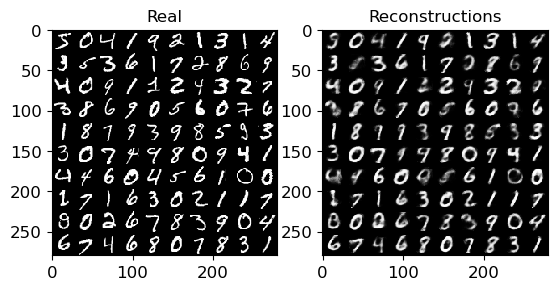

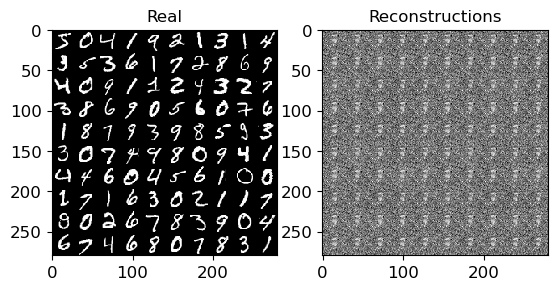

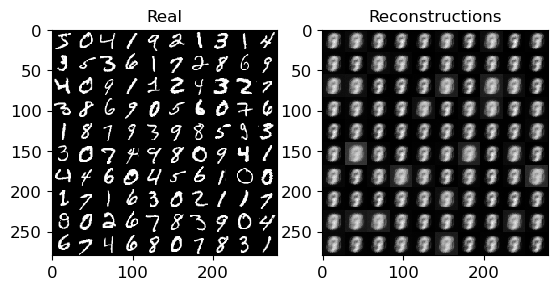

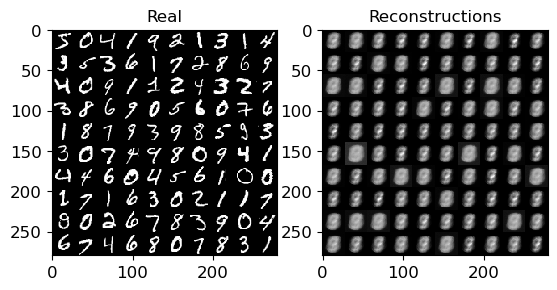

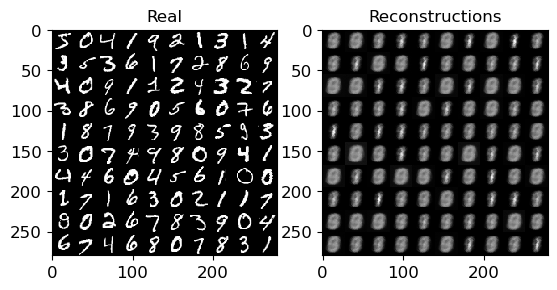

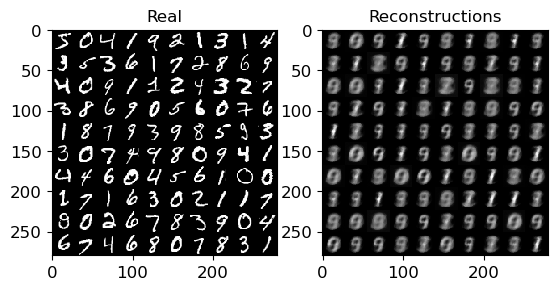

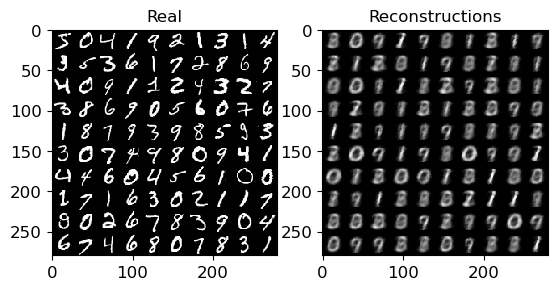

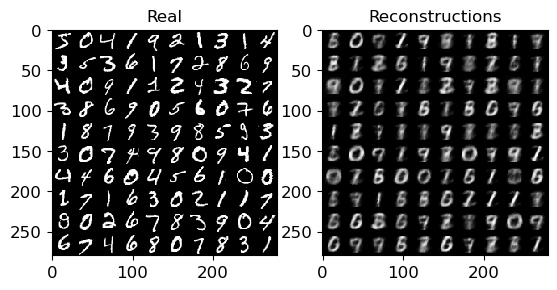

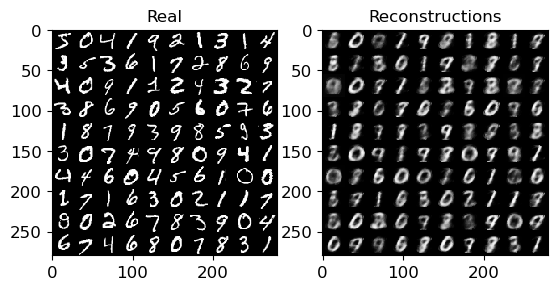

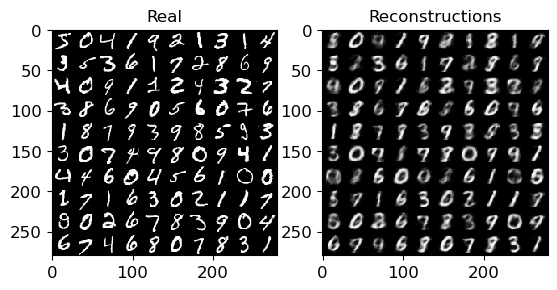

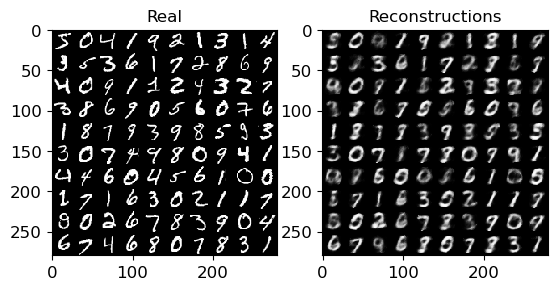

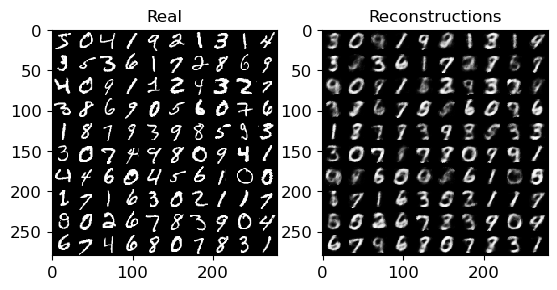

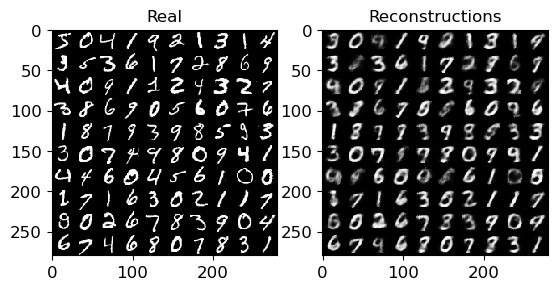

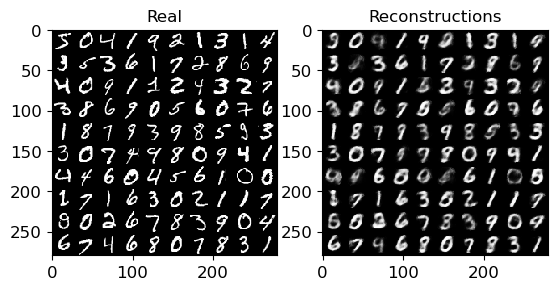

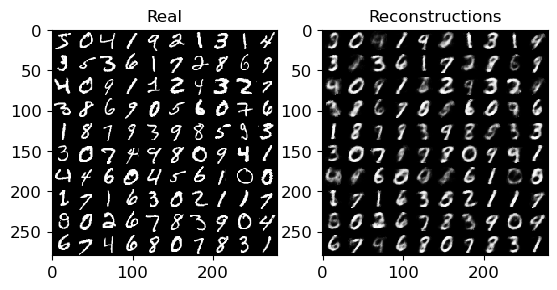

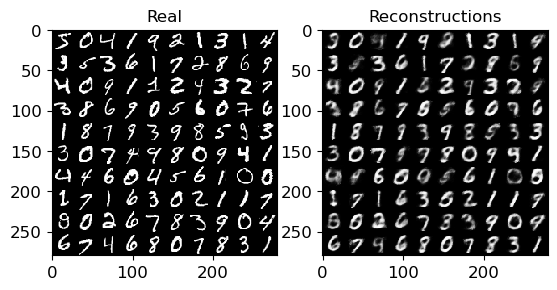

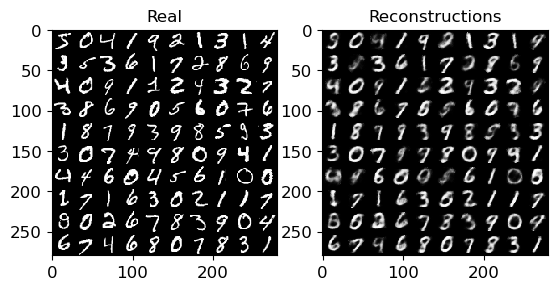

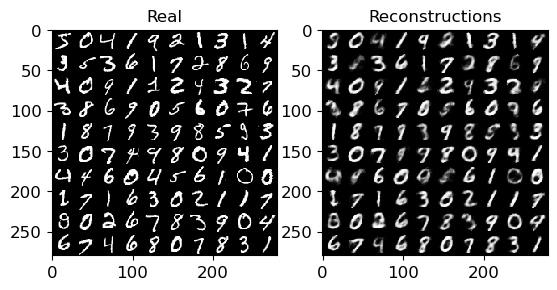

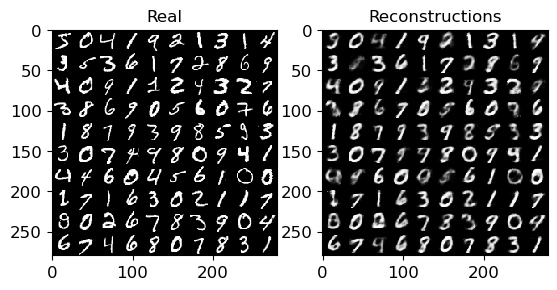

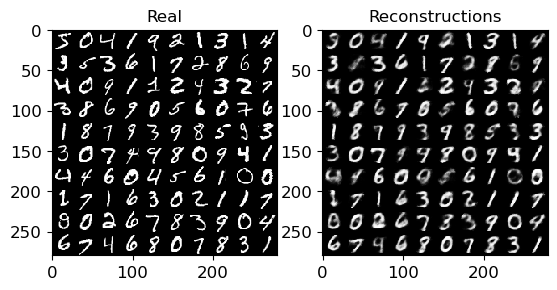

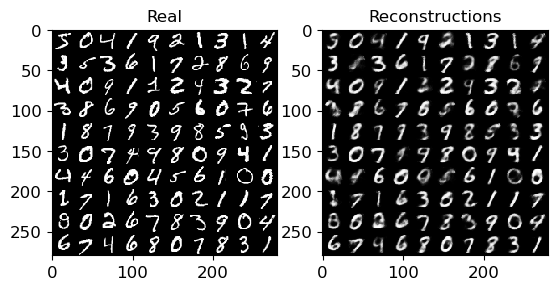

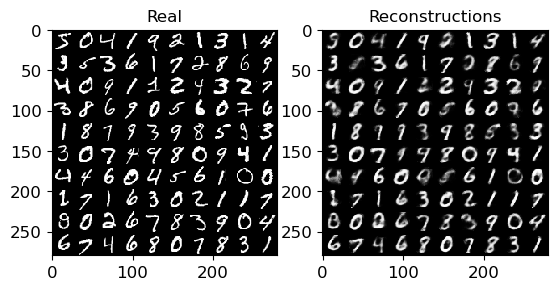

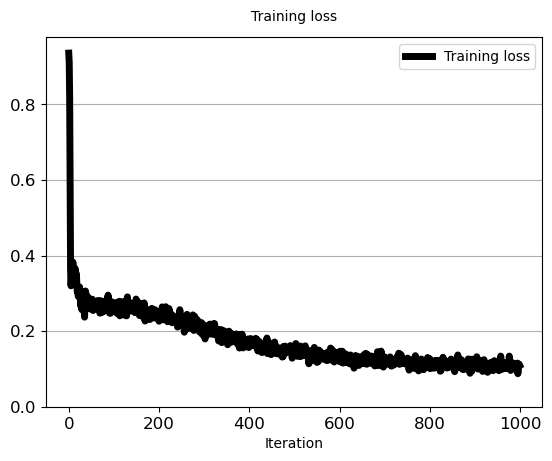

In [29]:
# The below is a copy paste from Task 2.
# ========== TODO: Use a bottleneck of 32 neurons and train it =================

# Create the network
rng = np.random.RandomState(seed=SEED)
autoencoder_wide = Autoencoder(rng=rng,
                               D_in=H_height*W_width,
                               D_hid_enc=256,
                               D_bottleneck=32,  # <--------- Width of Bottleneck
                               D_hid_dec=256)
# Start training
unsupervised_training_AE(autoencoder_wide,
                         reconstruction_loss,
                         rng,
                         train_imgs_flat,
                         batch_size=40,
                         learning_rate=3e-3,
                         total_iters=1000,
                         iters_per_recon_plot=50)

## Task 5: Decoder

An Encoder of an AE learns a mapping from x (image space) to z (code).\
A Decoder of an AE learns a mapping from z (code) to x (image space).

Using the Decoder of a pre-trained basic AE to try and synthesize non-existing data.\
No training involved

In [31]:
class Decoder():
    def __init__(self, pretrained_ae):
        ############ TODO: Fill in the gaps. The aim is: ... ############
        # ... to use the weights of the pre-trained AE's DECODER,... ####
        # ... to initialize this Decoder.                            ####
        # Reminder: pretrained_ae.params[LAYER] contrains the params of the corresponding layer. See Task 2.
        w1 = torch.tensor(pretrained_ae.params[2], dtype=torch.float, requires_grad=False)
        w2 = torch.tensor(pretrained_ae.params[3], dtype=torch.float, requires_grad=False) #YW: pretrained_ae, the model we are using, if autoencoder_wide then it will be autoencoder_wide.params[3] althought it is assigned as self.params[3] in the autoencoder function
        
        #YW: requires_grad=False: This ensures that these weights are not updated during training or decoding.
        self.params = [w1, w2]
        ###########################################################################
        
        
    def decode(self, z_batch):
        # Reconstruct a batch of images from a batch of z codes.
        # z_batch: Random codes. Numpy array of shape: [batch size, number of z dimensions]
        [w1, w2] = self.params #YW: Retrieves the pre-trained decoder weights stored in self.params
    
        z_batch_t = torch.tensor(z_batch, dtype=torch.float)  # Making a Pytorch tensor from Numpy array. ???????????? autoencoder_wide produces two output x_pred and z_code, why would it take z_code ??
        # Adding an activation with value 1, for the bias. Similar to Task 2.
        unary_feature_for_bias = torch.ones(size=(z_batch_t.shape[0], 1)) # [N, 1] column vector.
        
        ##### TODO: Fill in the gaps, to REPLICATE the decoder of the AE from Task 4 #####
        # Hidden Layer of Decoder:
        z_batch_act_ext = torch.cat((z_batch_t, unary_feature_for_bias), dim=1) #YW: adding bias, column of 1 
        h1_preact = z_batch_act_ext.mm(w1)
        h1_act = h1_preact.clamp(min=0) # <--------------- RELU, like the AE's decoder
        # Output Layer:
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w2)
        h2_act = torch.tanh(h2_preact)
        ##################################################################################
        # Output
        x_pred = h2_act
        
        return x_pred
        
# Lets instantiate this Decoder, using the pre-trained AE with 32-dims ("wider") bottleneck:
net_decoder_pretrained = Decoder(autoencoder_wide)

/var/folders/py/5l_zg9zs2lx223ngmhl0sbtm0000gn/T/ipykernel_51229/3158167702.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w1 = torch.tensor(pretrained_ae.params[2], dtype=torch.float, requires_grad=False)
/var/folders/py/5l_zg9zs2lx223ngmhl0sbtm0000gn/T/ipykernel_51229/3158167702.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w2 = torch.tensor(pretrained_ae.params[3], dtype=torch.float, requires_grad=False) #YW: pretrained_ae, the model we are using, if autoencoder_wide then it will be autoencoder_wide.params[3] althought it is assigned as self.params[3] in the autoencoder function


In [32]:
# NOTE: This function was implemented in Task 3. We simply call it again, but for a different AE, the wider.

# Encode training samples, and get the min and max values of the z codes (for each dimension)
min_z_wider, max_z_wider = encode_and_get_min_max_z(autoencoder_wide,
                                                    train_imgs_flat,
                                                    train_lbls,
                                                    batch_size=100,
                                                    total_iterations=None,  # So that it runs over all data.
                                                    plot_2d_embedding=False)  # Code is 32-Dims. Cant plot in 2D
print("Min Z value per dimension:", min_z_wider)
print("Max Z value per dimension:", max_z_wider)

Min Z value per dimension: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
Max Z value per dimension: [ 0.        0.       41.473335  0.       43.257755  0.        0.
  0.        0.        0.        0.        0.        0.        0.
  0.       49.599846 41.466576 36.70489   0.       41.00819   0.
 36.825268  0.       41.80135  38.391468  0.        0.       43.364143
  0.        0.        0.       40.230366]


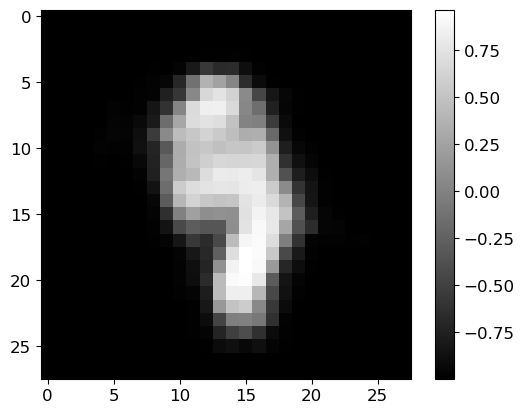

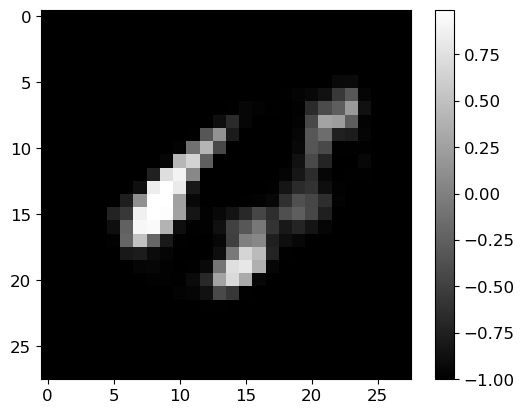

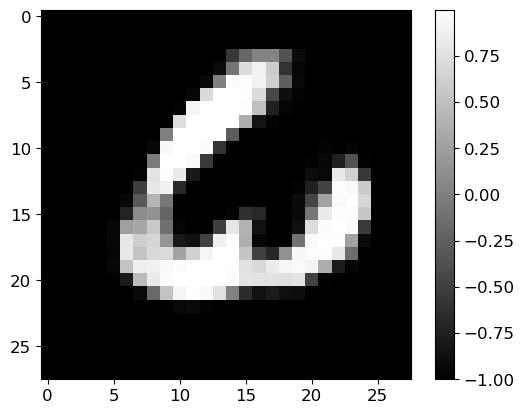

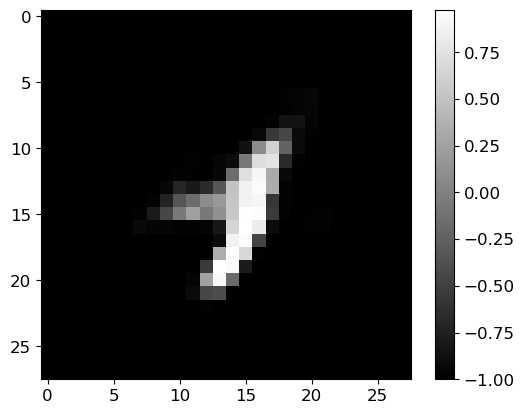

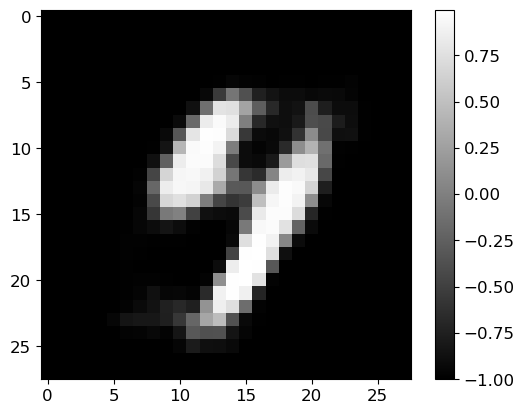

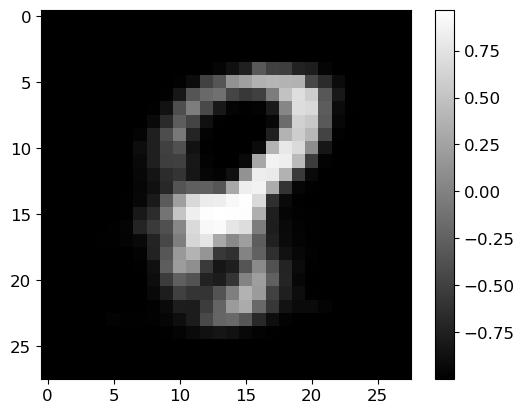

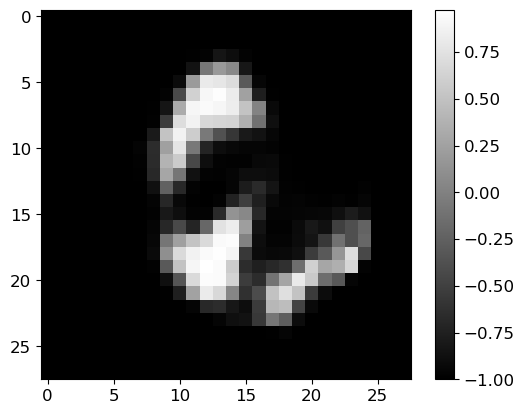

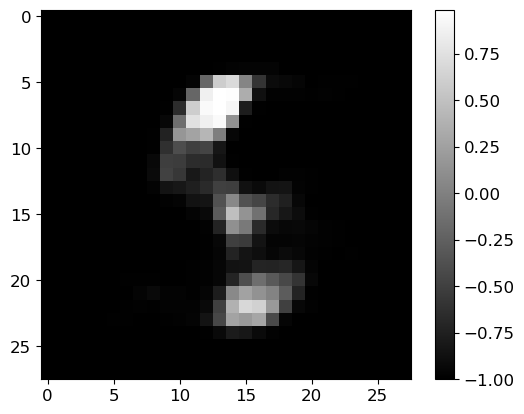

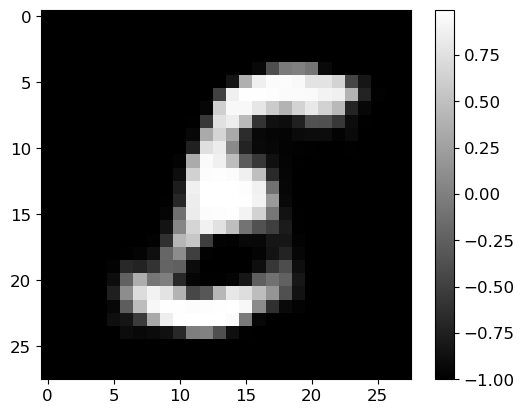

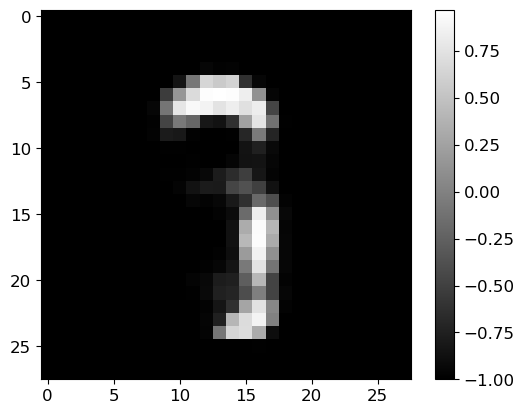

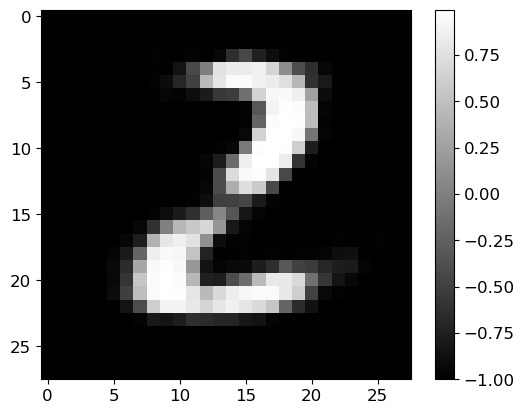

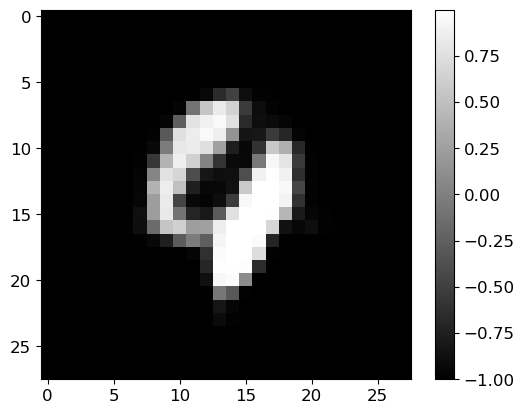

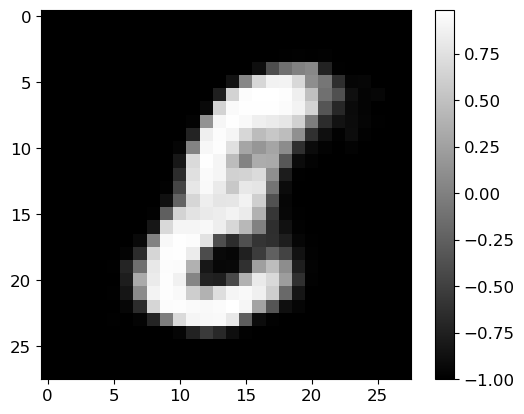

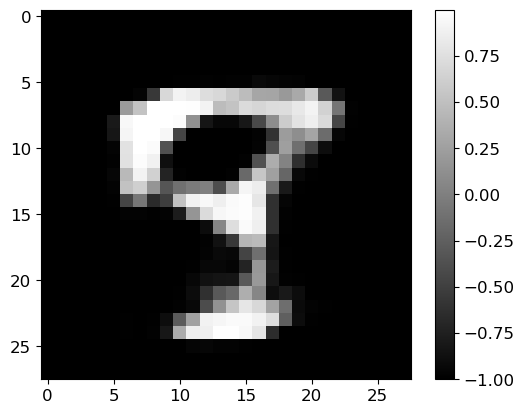

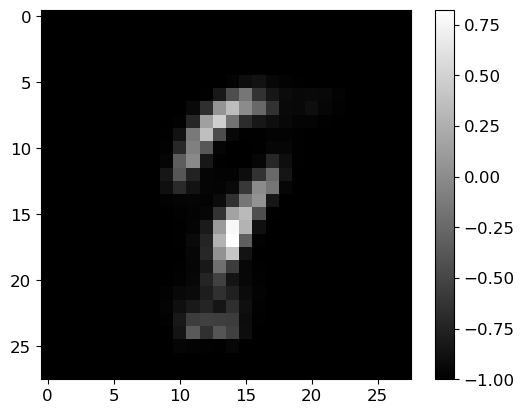

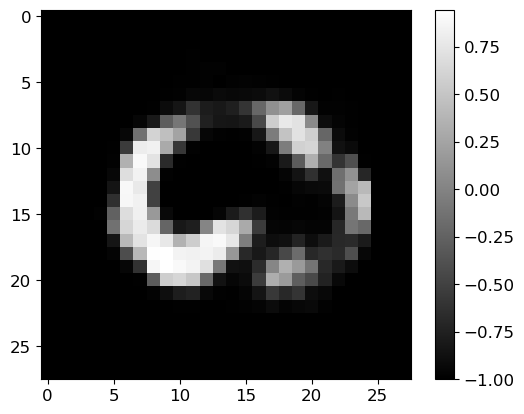

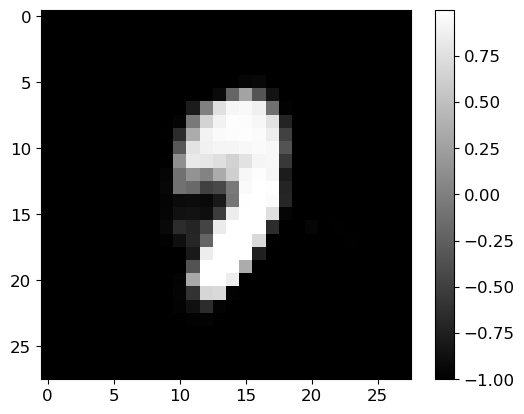

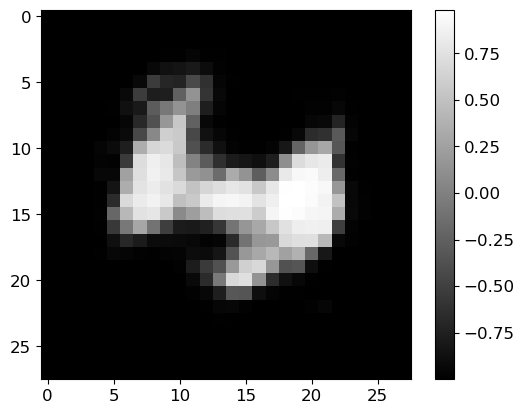

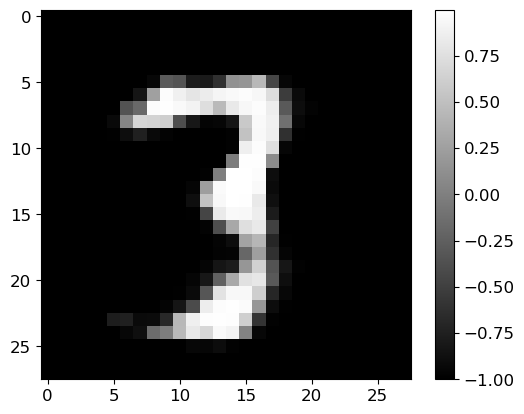

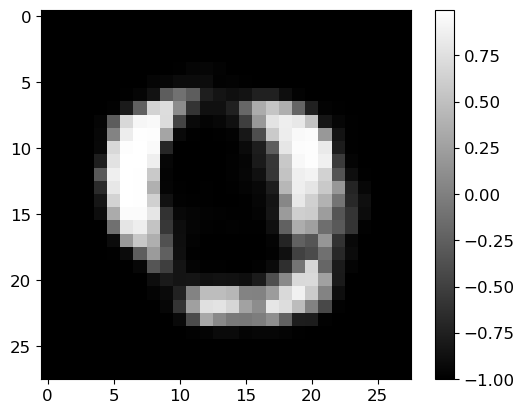

In [33]:
def synthesize(net_decoder,
               rng,
               z_min,
               z_max,
               n_samples):
    # net_decoder: Decoder with pre-trained weights.
    # z_min: numpy array (vector) of shape [dimensions-of-z]
    # z_max: numpy array (vector) of shape [dimensions-of-z]
    # n_samples: how many samples to produce.
    
    assert len(z_min.shape) == 1 and len(z_max.shape) == 1
    assert z_min.shape[0] == z_max.shape[0]

    #YW: assert: test assumptions or conditions in your code. True - continue, False - AssertionError and stop 
  
    z_dims = z_min.shape[0]  # Dimensionality of z codes (and input to decoder). YW: extract the dimension of z space
    
    # Create samples of z uniformly sampled from [z_min, z_max]
    z_samples = np.random.random_sample([n_samples, z_dims])  # Returns N number of samples from uniform([0, 1)) YW: n_samples x z_dims array of random number in range [0,1)
    z_samples = z_samples * (z_max - z_min)  # Scales [0,1] range ==> [0,(max-min)] range
    z_samples = z_samples + z_min  # Puts the [0,(max-min)] range ==> [min, max] range
    
    x_samples = net_decoder.decode(z_samples)
    
    x_samples_np = x_samples if type(x_samples) is np.ndarray else x_samples.detach().numpy()  # torch to numpy
    #print(z_samples.shape) (20, 32)
    #print(x_samples_np.shape) (20, 784)
    
    for x_sample in x_samples_np:
        reshaped_image = x_sample.reshape([H_height, W_width])
        #print("Reshaped image shape:", reshaped_image.shape) 
        plot_image(reshaped_image)
        plt.show()
        plt.close()
    
# Lets finally run the synthesis and see what happens...
rng = np.random.RandomState(seed=SEED)

synthesize(net_decoder_pretrained,
           rng,
           min_z_wider,  # From further above
           max_z_wider,  # From further above
           n_samples=20)

## Task 6: Learning from Unlabelled data with AE, to complement Supervised Classifier when Labelled data are limited: Lets first train a supervised Classifier 'from scratch'

In [35]:
#YW: a classification neural network from scratch, just the decoder part
#YW: no different from a normal classification netwotk

class Classifier_3layers(Network):
    def __init__(self, D_in, D_hid_1, D_hid_2, D_out, rng):
        D_in = D_in
        D_hid_1 = D_hid_1
        D_hid_2 = D_hid_2
        D_out = D_out
        
        # === NOTE: Notice that this is exactly the same architecture as encoder of AE in Task 4 ====
        w_1_init = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, D_hid_1))
        w_2_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_1+1, D_hid_2))
        w_out_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_2+1, D_out))
        
        w_1 = torch.tensor(w_1_init, dtype=torch.float, requires_grad=True)
        w_2 = torch.tensor(w_2_init, dtype=torch.float, requires_grad=True)
        w_out = torch.tensor(w_out_init, dtype=torch.float, requires_grad=True)
        
        self.params = [w_1, w_2, w_out]
        
        
    def forward_pass(self, batch_inp):
        # compute predicted y
        [w_1, w_2, w_out] = self.params
        
        # In case input is image, make it a tensor.
        batch_imgs_t = torch.tensor(batch_inp, dtype=torch.float) if type(batch_inp) is np.ndarray else batch_inp
        
        unary_feature_for_bias = torch.ones(size=(batch_imgs_t.shape[0], 1)) # [N, 1] column vector.
        x = torch.cat((batch_imgs_t, unary_feature_for_bias), dim=1) # Extra feature=1 for bias.
        
        # === NOTE: This is the same architecture as encoder of AE in Task 4, with extra classification layer ===
        # Layer 1
        h1_preact = x.mm(w_1)
        h1_act = h1_preact.clamp(min=0)
        # Layer 2 (corresponds to bottleneck of the AE):
        h1_ext = torch.cat((h1_act, unary_feature_for_bias), dim=1)
        h2_preact = h1_ext.mm(w_2)
        h2_act = h2_preact.clamp(min=0)
        # Output classification layer
        h2_ext = torch.cat((h2_act, unary_feature_for_bias), dim=1)
        h_out = h2_ext.mm(w_out)
        
        logits = h_out
        
        # === Addition of a softmax function for 
        # Softmax activation function. YW: converts the output of the last hidden layer (or the logits) into a probability distribution over the possible classes.
        exp_logits = torch.exp(logits)
        y_pred = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True) 
        # sum with Keepdim=True returns [N,1] array. It would be [N] if keepdim=False.
        # Torch broadcasts [N,1] to [N,D_out] via repetition, to divide elementwise exp_h2 (which is [N,D_out]).
        
        return y_pred

    
def cross_entropy(y_pred, y_real, eps=1e-7):
    # y_pred: Predicted class-posterior probabilities, returned by forward_pass. Numpy array of shape [N, D_out]
    # y_real: One-hot representation of real training labels. Same shape as y_pred.
    
    # If number array is given, change it to a Torch tensor.
    y_pred = torch.tensor(y_pred, dtype=torch.float) if type(y_pred) is np.ndarray else y_pred
    y_real = torch.tensor(y_real, dtype=torch.float) if type(y_real) is np.ndarray else y_real
    
    x_entr_per_sample = - torch.sum( y_real*torch.log(y_pred+eps), dim=1)  # Sum over classes, axis=1
    
    loss = torch.mean(x_entr_per_sample, dim=0) # Expectation of loss: Mean over samples (axis=0).
    return loss



from utils.plotting import plot_train_progress_2

def train_classifier(classifier,
                     pretrained_AE,
                     loss_func,
                     rng,
                     train_imgs,
                     train_lbls,
                     test_imgs,
                     test_lbls,
                     batch_size,
                     learning_rate,
                     total_iters,
                     iters_per_test=-1):
    # Arguments:
    # classifier: A classifier network. It will be trained by this function using labelled data.
    #             Its input will be either original data (if pretrained_AE=0), ...
    #             ... or the output of the feature extractor if one is given.
    # pretrained_AE: A pretrained AutoEncoder that will *not* be trained here.
    #      It will be used to encode input data.
    #      The classifier will take as input the output of this feature extractor.
    #      If pretrained_AE = None: The classifier will simply receive the actual data as input.
    # train_imgs: Vectorized training images
    # train_lbls: One hot labels
    # test_imgs: Vectorized testing images, to compute generalization accuracy.
    # test_lbls: One hot labels for test data.
    # batch_size: batch size
    # learning_rate: come on...
    # total_iters: how many SGD iterations to perform.
    # iters_per_test: We will 'test' the model on test data every few iterations as specified by this.
    
    values_to_plot = {'loss':[], 'acc_train': [], 'acc_test': []}
    
    optimizer = optim.Adam(classifier.params, lr=learning_rate)
        
    for t in range(total_iters):
        # Sample batch for this SGD iteration
        train_imgs_batch, train_lbls_batch = get_random_batch(train_imgs, train_lbls, batch_size, rng)
        
        # Forward pass
        if pretrained_AE is None:
            inp_to_classifier = train_imgs_batch #YW: NO Z LATENT VARIABLE BECAUSE no pretrained autoencoder, then use training image as input to classifiser 
        else:
            _, z_codes = pretrained_AE.forward_pass(train_imgs_batch)  # AE encodes. Output will be given to Classifier, YW: forward_pass output x_pred and z_codes
            inp_to_classifier = z_codes
            
        y_pred = classifier.forward_pass(inp_to_classifier)
        
        # Compute loss:
        y_real = train_lbls_batch
        loss = loss_func(y_pred, y_real)  # Cross entropy
        
        # Backprop and updates.
        optimizer.zero_grad()
        grads = classifier.backward_pass(loss)
        optimizer.step()
        
        
        # ==== Report training loss and accuracy ======
        # y_pred and loss can be either np.array, or torch.tensor (see later). If tensor, make it np.array.
        y_pred_numpy = y_pred if type(y_pred) is np.ndarray else y_pred.detach().numpy()
        y_pred_lbls = np.argmax(y_pred_numpy, axis=1) # y_pred is soft/probability. Make it a hard one-hot label.
        y_real_lbls = np.argmax(y_real, axis=1)
        
        acc_train = np.mean(y_pred_lbls == y_real_lbls) * 100. # percentage
        
        loss_numpy = loss if type(loss) is type(float) else loss.item()
        print("[iter:", t, "]: Training Loss: {0:.2f}".format(loss), "\t Accuracy: {0:.2f}".format(acc_train))
        
        # =============== Every few iterations, show reconstructions ================#
        if t==total_iters-1 or t%iters_per_test == 0:
            if pretrained_AE is None:
                inp_to_classifier_test = test_imgs
            else:
                _, z_codes_test = pretrained_AE.forward_pass(test_imgs)
                inp_to_classifier_test = z_codes_test
                
            y_pred_test = classifier.forward_pass(inp_to_classifier_test)
            
            # ==== Report test accuracy ======
            y_pred_test_numpy = y_pred_test if type(y_pred_test) is np.ndarray else y_pred_test.detach().numpy()
            
            y_pred_lbls_test = np.argmax(y_pred_test_numpy, axis=1)
            y_real_lbls_test = np.argmax(test_lbls, axis=1)
            acc_test = np.mean(y_pred_lbls_test == y_real_lbls_test) * 100.
            print("\t\t\t\t\t\t\t\t Testing Accuracy: {0:.2f}".format(acc_test))
            
            # Keep list of metrics to plot progress.
            values_to_plot['loss'].append(loss_numpy)
            values_to_plot['acc_train'].append(acc_train)
            values_to_plot['acc_test'].append(acc_test)
                
    # In the end of the process, plot loss accuracy on training and testing data.
    plot_train_progress_2(values_to_plot['loss'], values_to_plot['acc_train'], values_to_plot['acc_test'], iters_per_test)
    

[iter: 0 ]: Training Loss: 2.30 	 Accuracy: 7.50
								 Testing Accuracy: 11.88
[iter: 1 ]: Training Loss: 2.31 	 Accuracy: 12.50
[iter: 2 ]: Training Loss: 2.30 	 Accuracy: 5.00
[iter: 3 ]: Training Loss: 2.31 	 Accuracy: 7.50
[iter: 4 ]: Training Loss: 2.29 	 Accuracy: 10.00
[iter: 5 ]: Training Loss: 2.28 	 Accuracy: 15.00
[iter: 6 ]: Training Loss: 2.29 	 Accuracy: 12.50
[iter: 7 ]: Training Loss: 2.30 	 Accuracy: 2.50
[iter: 8 ]: Training Loss: 2.25 	 Accuracy: 17.50
[iter: 9 ]: Training Loss: 2.23 	 Accuracy: 35.00
[iter: 10 ]: Training Loss: 2.17 	 Accuracy: 30.00
[iter: 11 ]: Training Loss: 2.23 	 Accuracy: 10.00
[iter: 12 ]: Training Loss: 2.20 	 Accuracy: 15.00
[iter: 13 ]: Training Loss: 2.22 	 Accuracy: 0.00
[iter: 14 ]: Training Loss: 2.14 	 Accuracy: 15.00
[iter: 15 ]: Training Loss: 2.10 	 Accuracy: 17.50
[iter: 16 ]: Training Loss: 1.93 	 Accuracy: 32.50
[iter: 17 ]: Training Loss: 2.04 	 Accuracy: 30.00
[iter: 18 ]: Training Loss: 1.91 	 Accuracy: 27.50
[iter: 19 ]: 

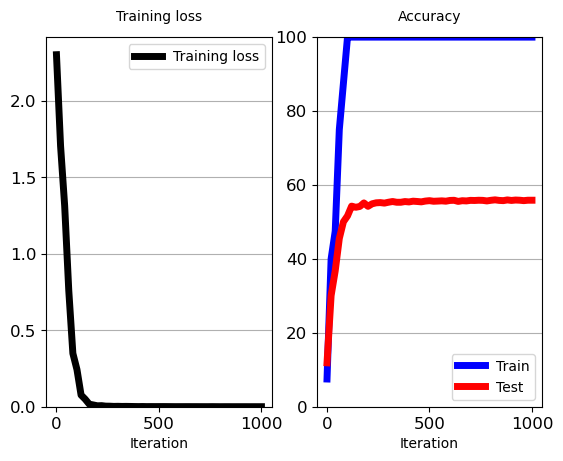

In [36]:
# Train Classifier from scratch (initialized randomly)

# Create the network
rng = np.random.RandomState(seed=SEED)
net_classifier_from_scratch = Classifier_3layers(D_in=H_height*W_width,
                                                 D_hid_1=256, # TODO: Use same as layer 1 of encoder of wide AE (Task 4)
                                                 D_hid_2=32,  # TODO: Use same as layer 2 of encoder of wide AE (Task 4)
                                                 D_out=C_classes,
                                                 rng=rng)
# Start training
train_classifier(net_classifier_from_scratch,
                 None,  # No pretrained AE
                 cross_entropy,
                 rng,
                 train_imgs_flat[:100],
                 train_lbls_onehot[:100],
                 test_imgs_flat,
                 test_lbls_onehot,
                 batch_size=40,
                 learning_rate=3e-3,
                 total_iters=1000,
                 iters_per_test=20)


[iter: 0 ]: Training Loss: 2.44 	 Accuracy: 0.00
								 Testing Accuracy: 12.05
[iter: 1 ]: Training Loss: 2.26 	 Accuracy: 12.50
[iter: 2 ]: Training Loss: 2.08 	 Accuracy: 15.00
[iter: 3 ]: Training Loss: 2.16 	 Accuracy: 7.50
[iter: 4 ]: Training Loss: 2.00 	 Accuracy: 35.00
[iter: 5 ]: Training Loss: 1.78 	 Accuracy: 60.00
[iter: 6 ]: Training Loss: 1.90 	 Accuracy: 30.00
[iter: 7 ]: Training Loss: 1.80 	 Accuracy: 47.50
[iter: 8 ]: Training Loss: 1.74 	 Accuracy: 40.00
[iter: 9 ]: Training Loss: 1.68 	 Accuracy: 50.00
[iter: 10 ]: Training Loss: 1.58 	 Accuracy: 62.50
[iter: 11 ]: Training Loss: 1.50 	 Accuracy: 65.00
[iter: 12 ]: Training Loss: 1.37 	 Accuracy: 70.00
[iter: 13 ]: Training Loss: 1.43 	 Accuracy: 75.00
[iter: 14 ]: Training Loss: 1.37 	 Accuracy: 65.00
[iter: 15 ]: Training Loss: 1.34 	 Accuracy: 60.00
[iter: 16 ]: Training Loss: 1.44 	 Accuracy: 57.50
[iter: 17 ]: Training Loss: 1.41 	 Accuracy: 72.50
[iter: 18 ]: Training Loss: 1.38 	 Accuracy: 72.50
[iter: 19 

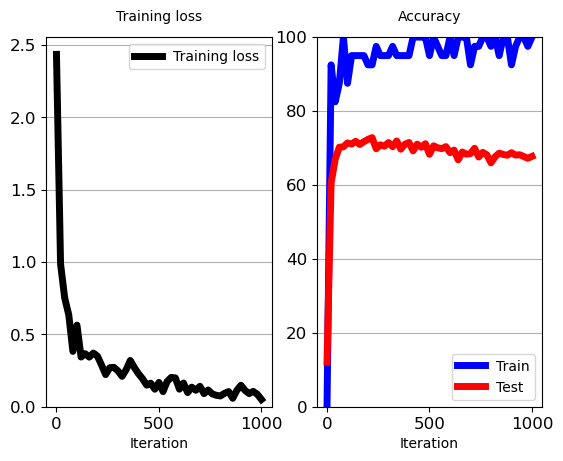

[iter: 0 ]: Training Loss: 0.00 	 Accuracy: 100.00
								 Testing Accuracy: 47.94
[iter: 1 ]: Training Loss: 0.05 	 Accuracy: 97.50
[iter: 2 ]: Training Loss: 0.00 	 Accuracy: 100.00
[iter: 3 ]: Training Loss: 0.02 	 Accuracy: 100.00
[iter: 4 ]: Training Loss: 0.16 	 Accuracy: 92.50
[iter: 5 ]: Training Loss: 0.01 	 Accuracy: 100.00
[iter: 6 ]: Training Loss: 0.00 	 Accuracy: 100.00
[iter: 7 ]: Training Loss: 0.06 	 Accuracy: 100.00
[iter: 8 ]: Training Loss: 0.05 	 Accuracy: 95.00
[iter: 9 ]: Training Loss: 0.01 	 Accuracy: 100.00
[iter: 10 ]: Training Loss: 0.00 	 Accuracy: 100.00
[iter: 11 ]: Training Loss: 0.00 	 Accuracy: 100.00
[iter: 12 ]: Training Loss: 0.00 	 Accuracy: 100.00
[iter: 13 ]: Training Loss: 0.01 	 Accuracy: 100.00
[iter: 14 ]: Training Loss: 0.01 	 Accuracy: 100.00
[iter: 15 ]: Training Loss: 0.01 	 Accuracy: 100.00
[iter: 16 ]: Training Loss: 0.00 	 Accuracy: 100.00
[iter: 17 ]: Training Loss: 0.00 	 Accuracy: 100.00
[iter: 18 ]: Training Loss: 0.00 	 Accuracy:

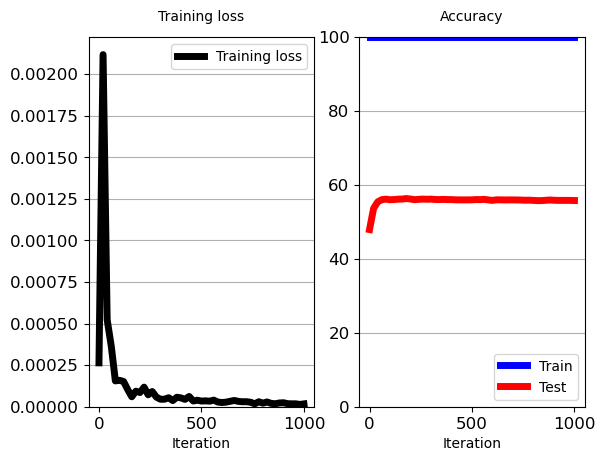

In [37]:
# Train classifier on top of pre-trained AE encoder

class Classifier_1layer(Network):
    # Classifier with just 1 layer, the classification layer
    def __init__(self, D_in, D_out, rng):
        # D_in: dimensions of input
        # D_out: dimension of output (number of classes)
        
        #### TODO: Fill in the blanks ######################
        w_out_init = rng.normal(loc=0.0, scale=0.01, size=(D_in+1, D_out))
        w_out = torch.tensor(w_out_init, dtype=torch.float, requires_grad=True)
        ####################################################
        self.params = [w_out]
        
        
    def forward_pass(self, batch_inp):
        # compute predicted y
        [w_out] = self.params
        
        # In case input is image, make it a tensor.
        batch_inp_t = torch.tensor(batch_inp, dtype=torch.float) if type(batch_inp) is np.ndarray else batch_inp
        
        unary_feature_for_bias = torch.ones(size=(batch_inp_t.shape[0], 1)) # [N, 1] column vector.
        batch_inp_ext = torch.cat((batch_inp_t, unary_feature_for_bias), dim=1) # Extra feature=1 for bias.
        
        # Output classification layer
        logits = batch_inp_ext.mm(w_out)
        
        # Output layer activation function
        # Softmax activation function.
        exp_logits = torch.exp(logits)
        y_pred = exp_logits / torch.sum(exp_logits, dim=1, keepdim=True) 
        # sum with Keepdim=True returns [N,1] array. It would be [N] if keepdim=False.
        # Torch broadcasts [N,1] to [N,D_out] via repetition, to divide elementwise exp_h2 (which is [N,D_out]).
        
        return y_pred
    
    
    
# Create the network
rng = np.random.RandomState(seed=SEED) # Random number generator
# As input, it will be getting z-codes from the AE with 32-neurons bottleneck from Task 4.
#YW: INPUT using the Z latent variable for each image based on the pre trained AE
classifier_1layer = Classifier_1layer(autoencoder_wide.D_bottleneck,  # Input dimension is dimensions of AE's Z
                                      C_classes,
                                      rng=rng)

########### TODO: Fill in the gaps to start training ####################
# Give to the function the 1-layer classifier, as well as the pre-trained AE that will work as feature extractor.
# For the pre-trained AE, give the instance of 'wide' AE that has 32-neurons bottleneck, which you trained in Task 4.
train_classifier(classifier_1layer,
                 autoencoder_wide,  # Pretrained AE, to use as feature extractor.
                 cross_entropy,
                 rng,
                 train_imgs_flat[:100],
                 train_lbls_onehot[:100],
                 test_imgs_flat,
                 test_lbls_onehot,
                 batch_size=40,
                 learning_rate=3e-3,   # 5e-3, is the best for 1-layer classifier and all data.
                 total_iters=1000,
                 iters_per_test=20)

train_classifier(net_classifier_from_scratch,
                 None,  # No pretrained AE
                 cross_entropy,
                 rng,
                 train_imgs_flat[:100],
                 train_lbls_onehot[:100],
                 test_imgs_flat,
                 test_lbls_onehot,
                 batch_size=40,
                 learning_rate=3e-3,
                 total_iters=1000,
                 iters_per_test=20)


## Task 8: Use parameters of an Unsupervised AE's encoder to initialize weights of a supervised Classifier, followed by refinement using limited labels


[iter: 0 ]: Training Loss: 2.44 	 Accuracy: 0.00
								 Testing Accuracy: 11.88
[iter: 1 ]: Training Loss: 2.19 	 Accuracy: 12.50
[iter: 2 ]: Training Loss: 2.04 	 Accuracy: 22.50
[iter: 3 ]: Training Loss: 2.11 	 Accuracy: 15.00
[iter: 4 ]: Training Loss: 1.90 	 Accuracy: 42.50
[iter: 5 ]: Training Loss: 1.68 	 Accuracy: 67.50
[iter: 6 ]: Training Loss: 1.72 	 Accuracy: 42.50
[iter: 7 ]: Training Loss: 1.58 	 Accuracy: 62.50
[iter: 8 ]: Training Loss: 1.56 	 Accuracy: 60.00
[iter: 9 ]: Training Loss: 1.37 	 Accuracy: 65.00
[iter: 10 ]: Training Loss: 1.20 	 Accuracy: 65.00
[iter: 11 ]: Training Loss: 1.11 	 Accuracy: 70.00
[iter: 12 ]: Training Loss: 0.89 	 Accuracy: 72.50
[iter: 13 ]: Training Loss: 0.98 	 Accuracy: 70.00
[iter: 14 ]: Training Loss: 0.86 	 Accuracy: 75.00
[iter: 15 ]: Training Loss: 0.75 	 Accuracy: 77.50
[iter: 16 ]: Training Loss: 0.95 	 Accuracy: 77.50
[iter: 17 ]: Training Loss: 0.86 	 Accuracy: 82.50
[iter: 18 ]: Training Loss: 0.79 	 Accuracy: 82.50
[iter: 19

/var/folders/py/5l_zg9zs2lx223ngmhl0sbtm0000gn/T/ipykernel_51229/3309531353.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_1 = torch.tensor(pretrained_AE.params[0], dtype=torch.float, requires_grad=True)
/var/folders/py/5l_zg9zs2lx223ngmhl0sbtm0000gn/T/ipykernel_51229/3309531353.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  w_2 = torch.tensor(pretrained_AE.params[1], dtype=torch.float, requires_grad=True)


								 Testing Accuracy: 67.63
[iter: 41 ]: Training Loss: 0.18 	 Accuracy: 95.00
[iter: 42 ]: Training Loss: 0.09 	 Accuracy: 100.00
[iter: 43 ]: Training Loss: 0.16 	 Accuracy: 97.50
[iter: 44 ]: Training Loss: 0.08 	 Accuracy: 100.00
[iter: 45 ]: Training Loss: 0.09 	 Accuracy: 100.00
[iter: 46 ]: Training Loss: 0.12 	 Accuracy: 100.00
[iter: 47 ]: Training Loss: 0.10 	 Accuracy: 100.00
[iter: 48 ]: Training Loss: 0.08 	 Accuracy: 100.00
[iter: 49 ]: Training Loss: 0.13 	 Accuracy: 100.00
[iter: 50 ]: Training Loss: 0.07 	 Accuracy: 100.00
[iter: 51 ]: Training Loss: 0.08 	 Accuracy: 100.00
[iter: 52 ]: Training Loss: 0.07 	 Accuracy: 100.00
[iter: 53 ]: Training Loss: 0.06 	 Accuracy: 100.00
[iter: 54 ]: Training Loss: 0.06 	 Accuracy: 100.00
[iter: 55 ]: Training Loss: 0.07 	 Accuracy: 100.00
[iter: 56 ]: Training Loss: 0.07 	 Accuracy: 100.00
[iter: 57 ]: Training Loss: 0.05 	 Accuracy: 100.00
[iter: 58 ]: Training Loss: 0.03 	 Accuracy: 100.00
[iter: 59 ]: Training Loss: 0.03 

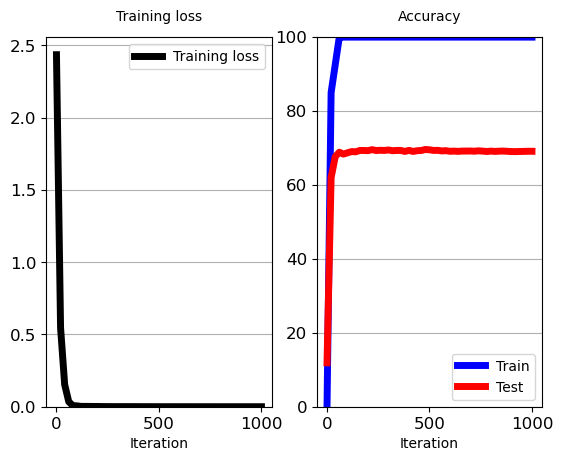

In [39]:
# Pre-train a classifier.

# The below classifier has THE SAME architecture as the 3-layer Classifier that we trained...
# ... in a purely supervised manner in Task-6.
# This is done by inheriting the class (Classifier_3layers), therefore uses THE SAME forward_pass() function.
# THE ONLY DIFFERENCE is in the construction __init__.
# This 'pretrained' classifier receives as input a pretrained autoencoder (pretrained_AE) from Task 4.
# It then uses the parameters of the AE's encoder to initialize its own parameters, rather than random initialization.
# The model is then trained all together.
class Classifier_3layers_pretrained(Classifier_3layers):
    def __init__(self, pretrained_AE, D_in, D_out, rng):
        D_in = D_in
        D_hid_1 = 256
        D_hid_2 = 32
        D_out = D_out

        w_out_init = rng.normal(loc=0.0, scale=0.01, size=(D_hid_2+1, D_out))
        
        w_1 = torch.tensor(pretrained_AE.params[0], dtype=torch.float, requires_grad=True)
        w_2 = torch.tensor(pretrained_AE.params[1], dtype=torch.float, requires_grad=True)
        w_out = torch.tensor(w_out_init, dtype=torch.float, requires_grad=True)
        
        self.params = [w_1, w_2, w_out]
        
# Create the network
rng = np.random.RandomState(seed=SEED) # Random number generator
classifier_3layers_pretrained = Classifier_3layers_pretrained(autoencoder_wide,  # The AE pre-trained in Task 4.
                                                              train_imgs_flat.shape[1],
                                                              C_classes,
                                                              rng=rng)

# Start training
# NOTE: Only the 3-layer pretrained classifier is used, and will be trained all together.
# No frozen feature extractor.
train_classifier(classifier_3layers_pretrained,  # classifier that will be trained.
                 None,  # No pretrained AE to act as 'frozen' feature extractor.
                 cross_entropy,
                 rng,
                 train_imgs_flat[:100],
                 train_lbls_onehot[:100],
                 test_imgs_flat,
                 test_lbls_onehot,
                 batch_size=40,
                 learning_rate=3e-3,
                 total_iters=1000,
                 iters_per_test=20)

## This notebook:
Copyright 2021, University of Birmingham  
Tutorial for Neural Computation  
For issues e-mail: k.kamnitsas@bham.ac.uk